Author: Ballanti Chiara (ballanti.1844613@studenti.uniroma1.it)

# **Audio task arithmetic**

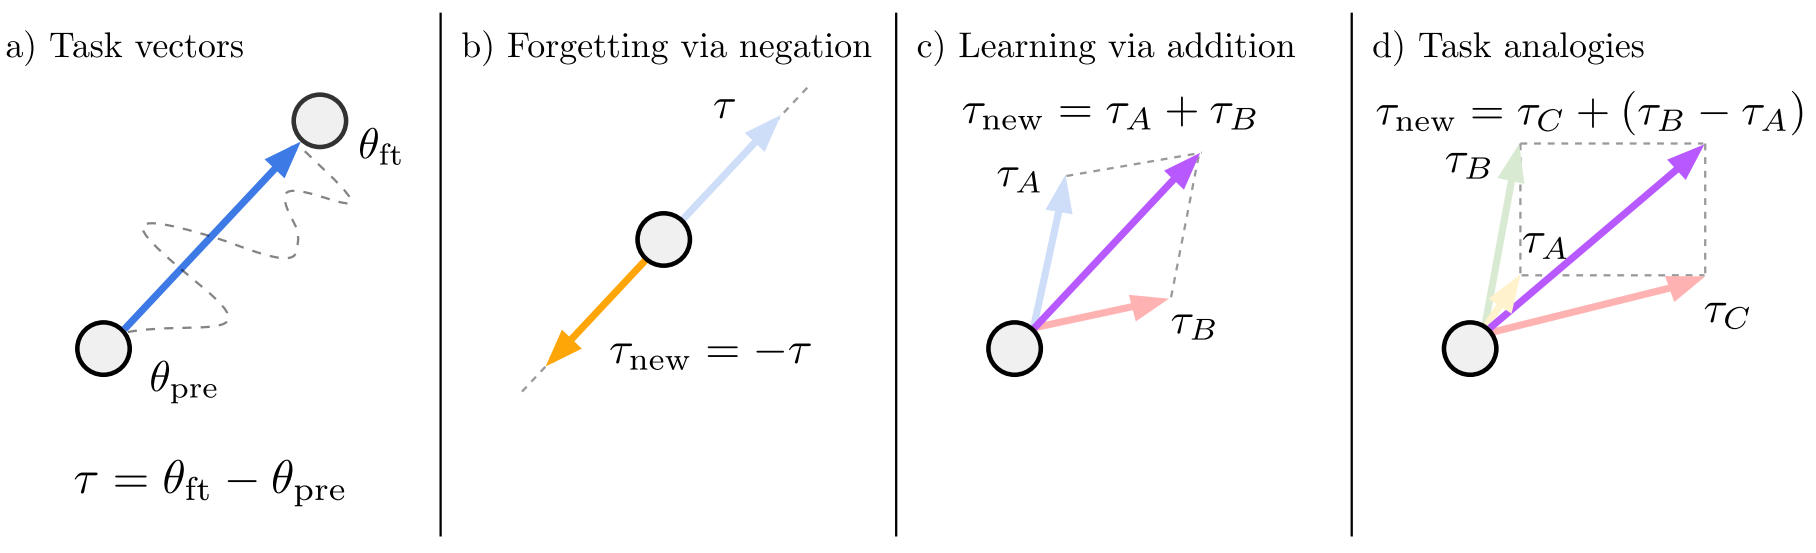

A  task is instantiated by a dataset and a loss function used for fine-tuning.

Let $\theta_{pt} \in \mathbb{R}^d$, be the weights of a pre-trained model, and $\theta_{ft} \in \mathbb{R}^d$ the corresponding weights after
fine-tuning on a specific task.\
A **task vector** $\tau \in \mathbb{R}^d$ specifies a direction in the weight space of a pre-trained model, such that movement in that direction improves performance on the task.
$\tau$ is a vector obtained by taking the element-wise difference between the weights of a pre-trained model and the weights of the same model after fine-tuning on a specific task:
$$\tau = \theta_{ft} - \theta_{pt}$$

Task vectors can be applied to any model parameters $\theta$ from the **same architecture**, via element-wise
addition, with an optional scaling term $\lambda$, such that the resulting model has weights $\theta_{new} = \theta + \lambda \tau$.


## **Editing models with task arithmetics**

Task vectors operations enable efficient model editing and knowledge transfer across tasks without the need for retraining. They offer a powerful and efficient way to adapt and refine models for various applications:

1. **Forgetting via negation**: negating a task vector decreases performance on the target task, with little change in model behavior on control tasks.
2. **Learning by addition**:  adding task vectors together can improve performance on multiple tasks at once.
3. **Task analogy**: when tasks are
linked by an analogy relationship of the form “*A* is to *B* as *C* is to *D* ”, combining task vectors from three of the tasks can improve performance on the fourth, even when no data from the fourth task is used for training.



In [ ]:
! rm -rf /content/sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Audio_Task_Arithmetic
!pwd

/content/drive/MyDrive/Audio_Task_Vectors
/content/drive/MyDrive/Audio_Task_Vectors


# Install dependencies

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install datasets evaluate adjustText
!pip install transformers[torch] accelerate -U

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-mrjlxses
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-mrjlxses
  Resolved https://github.com/huggingface/transformers to commit c1aa0edb48217f416f4bbe6e3a9db1500284513b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.44.0.dev0-py3-none-any.whl size=9425899 sha256=bef8511d7e0fa50a4dac644f5ba7a031953222d67161cee01050712c66f533b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6dzu7zj/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Prepare datasets

In [ ]:
from utils.prepare_datasets import *
from transformers import AutoProcessor

In [ ]:
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")

In [ ]:
dataset_name = ["gtzan", "esc50", "ub8k"]

for d in dataset_name:
  dir_data = f'/content/drive/MyDrive/Audio_Task_Arithmetic/data/{d}/'
  create_directory_if_not_exists(dir_data)

  if d == "gtzan":
    train_batches, val_batches, test_batches = prepare_GTZAN(BATCH_SIZE, processor)
  elif d == "esc50":
    train_batches, val_batches, test_batches = prepare_ESC50(BATCH_SIZE, processor)
  elif d == "ub8k": # UrbanSound8k
    train_batches, val_batches, test_batches = prepare_UB8k(BATCH_SIZE, processor)

  save_data(train_batches, val_batches, test_batches, dir_data + 'train_batches.pkl',
            dir_data + 'val_batches.pkl', dir_data + 'test_batches.pkl')

  del(train_batches, val_batches, test_batches)

In [ ]:
# Analogy: ESC50 + gender emotion recognition
for t in "ABCD":
  dir_data = f'/content/drive/MyDrive/Audio_Task_Arithmetic/data/{t}/'
  create_directory_if_not_exists(dir_data)
  train_batches, val_batches, test_batches = prepare_analogy(BATCH_SIZE, processor, t)
  save_data(train_batches, val_batches, test_batches, dir_data + 'train_batches.pkl',
            dir_data + 'val_batches.pkl', dir_data + 'test_batches.pkl')

  del(train_batches, val_batches, test_batches)

# Finetuning Clap

In [ ]:
import torch
from utils.utils import *
from utils.finetuning import *
from transformers import ClapModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save the checkpoint of the pre-trained model
model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
model = model.to(device)

# print(model)

pretrained_dir = "/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/"
create_directory_if_not_exists(pretrained_dir)

torch.save(model.state_dict(), pretrained_dir+"pretrained.pth")

del(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Directory '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/' already exists.


Epoch: 0 | ---: 100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


	Training loss: 0.03419


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


	Validation loss: 0.03896


Epoch: 1 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.03086


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


	Validation loss: 0.03651


Epoch: 2 | ---: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


	Training loss: 0.02944


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


	Validation loss: 0.03578


Epoch: 3 | ---: 100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


	Training loss: 0.02857


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


	Validation loss: 0.03541


Epoch: 4 | ---: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


	Training loss: 0.02778


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


	Validation loss: 0.03390


Epoch: 5 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02691


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


	Validation loss: 0.03356


Epoch: 6 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02641


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03288


Epoch: 7 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


	Training loss: 0.02609


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


	Validation loss: 0.03266


Epoch: 8 | ---: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


	Training loss: 0.02566


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03285


Epoch: 9 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


	Training loss: 0.02563


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


	Validation loss: 0.03289


Epoch: 10 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02515


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03233


Epoch: 11 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02501


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


	Validation loss: 0.03286


Epoch: 12 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02482


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


	Validation loss: 0.03248


Epoch: 13 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02478


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03216


Epoch: 14 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02462


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


	Validation loss: 0.03233


Epoch: 15 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


	Training loss: 0.02471


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


	Validation loss: 0.03246


Epoch: 16 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


	Training loss: 0.02462


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


	Validation loss: 0.03217


Epoch: 17 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02463


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


	Validation loss: 0.03284


Epoch: 18 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02457


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


	Validation loss: 0.03254


Epoch: 19 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02462


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


	Validation loss: 0.03246


Epoch: 20 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02456


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


	Validation loss: 0.03259


Epoch: 21 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02452


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03257


Epoch: 22 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02454


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


	Validation loss: 0.03239


Epoch: 23 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02451


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03232


Epoch: 24 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02462


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


	Validation loss: 0.03250


Epoch: 25 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02447


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


	Validation loss: 0.03251


Epoch: 26 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02443


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


	Validation loss: 0.03245


Epoch: 27 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02447


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


	Validation loss: 0.03266


Epoch: 28 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02444


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


	Validation loss: 0.03259


Epoch: 29 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02449


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


	Validation loss: 0.03241


Epoch: 30 | ---: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


	Training loss: 0.02447


	| ---: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


	Validation loss: 0.03239


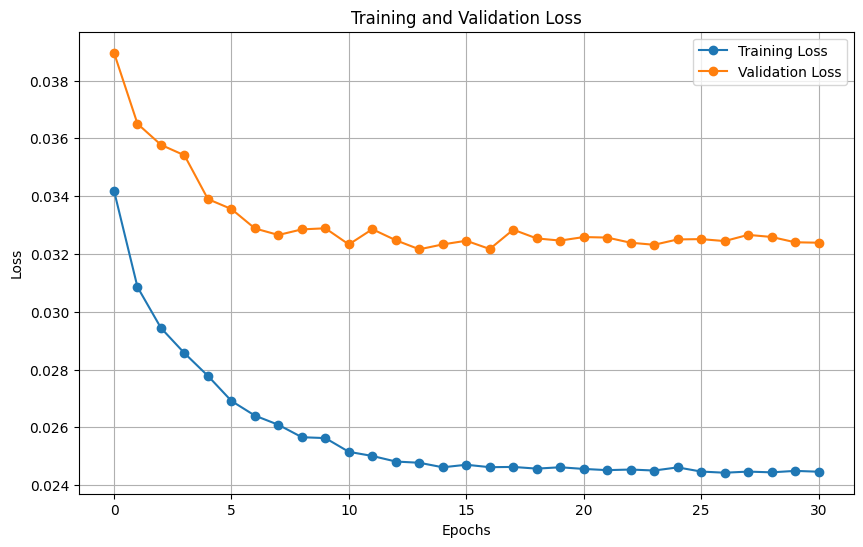

In [ ]:
finetuning_CLAP("gtzan", epochs=31, learning_rate=7e-5, step_lr=10, gamma=0.3)

Directory '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/' already exists.


Epoch: 0 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.027


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


	Validation loss: 0.032


Epoch: 1 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.025


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.030


Epoch: 2 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.025


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


	Validation loss: 0.029


Epoch: 3 | ---: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


	Training loss: 0.024


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


	Validation loss: 0.029


Epoch: 4 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.024


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


	Validation loss: 0.030


Epoch: 5 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.024


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


	Validation loss: 0.029


Epoch: 6 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.024


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


	Validation loss: 0.028


Epoch: 7 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.029


Epoch: 8 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


	Validation loss: 0.028


Epoch: 9 | ---: 100%|██████████| 33/33 [00:36<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.028


Epoch: 10 | ---: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


	Validation loss: 0.028


Epoch: 11 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


	Validation loss: 0.028


Epoch: 12 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.028


Epoch: 13 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


	Validation loss: 0.028


Epoch: 14 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


	Validation loss: 0.028


Epoch: 15 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


	Validation loss: 0.028


Epoch: 16 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


	Validation loss: 0.028


Epoch: 17 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


	Validation loss: 0.028


Epoch: 18 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.028


Epoch: 19 | ---: 100%|██████████| 33/33 [00:35<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


	Validation loss: 0.028


Epoch: 20 | ---: 100%|██████████| 33/33 [00:36<00:00,  1.09s/it]


	Training loss: 0.023


	| ---: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


	Validation loss: 0.028


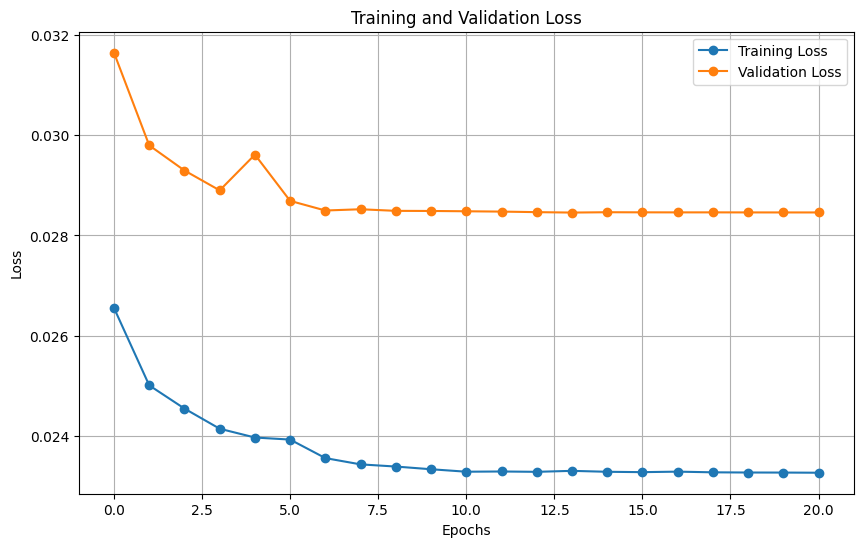

In [ ]:
finetuning_CLAP("ub8k", epochs=21, learning_rate=1e-4, step_lr=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Directory '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/' already exists.


Epoch: 0 | ---: 100%|██████████| 26/26 [00:31<00:00,  1.20s/it]


	Training loss: 0.05651


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


	Validation loss: 0.06570


Epoch: 1 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


	Training loss: 0.05239


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06377


Epoch: 2 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


	Training loss: 0.05093


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


	Validation loss: 0.06278


Epoch: 3 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04999


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


	Validation loss: 0.06282


Epoch: 4 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04960


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06205


Epoch: 5 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04915


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06135


Epoch: 6 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04881


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


	Validation loss: 0.06139


Epoch: 7 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04863


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


	Validation loss: 0.06109


Epoch: 8 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04848


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06074


Epoch: 9 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04818


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06050


Epoch: 10 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04800


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


	Validation loss: 0.06037


Epoch: 11 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04790


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06023


Epoch: 12 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04791


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


	Validation loss: 0.06019


Epoch: 13 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06037


Epoch: 14 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04790


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06022


Epoch: 15 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04796


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06015


Epoch: 16 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


	Validation loss: 0.06008


Epoch: 17 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04784


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


	Validation loss: 0.06012


Epoch: 18 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04790


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06005


Epoch: 19 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04775


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06003


Epoch: 20 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04778


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06005


Epoch: 21 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06004


Epoch: 22 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04779


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06004


Epoch: 23 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04779


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06003


Epoch: 24 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06004


Epoch: 25 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04779


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06003


Epoch: 26 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04780


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06002


Epoch: 27 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


	Validation loss: 0.06003


Epoch: 28 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04784


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06003


Epoch: 29 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


	Training loss: 0.04782


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06002


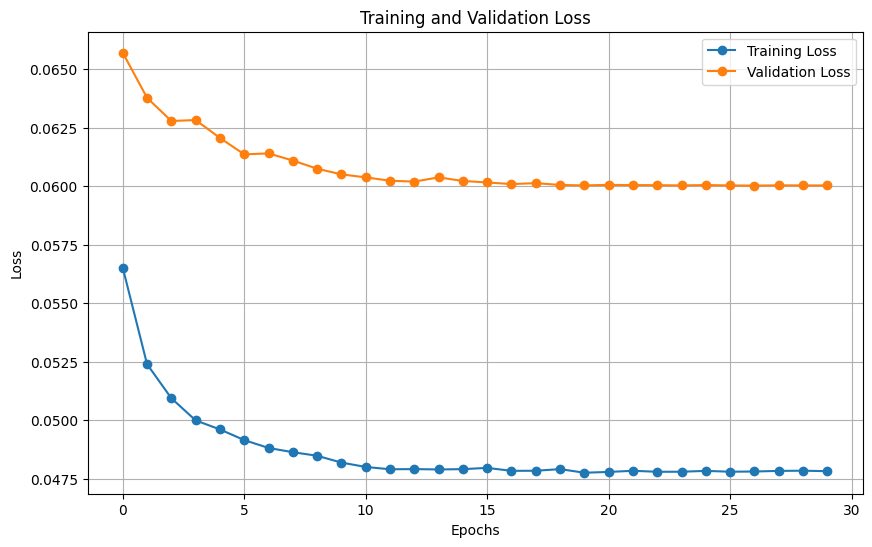

In [ ]:
torch.set_printoptions(precision=5)
finetuning_CLAP("A", epochs=30, learning_rate=1e-4, step_lr=5, gamma=0.5)

Directory '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/' already exists.


Epoch: 0 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


	Training loss: 0.05632


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


	Validation loss: 0.06637


Epoch: 1 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.05225


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06356


Epoch: 2 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.05098


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06385


Epoch: 3 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04988


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06294


Epoch: 4 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04970


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


	Validation loss: 0.06265


Epoch: 5 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04904


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06164


Epoch: 6 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04876


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06169


Epoch: 7 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04861


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06130


Epoch: 8 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04846


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06092


Epoch: 9 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04838


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


	Validation loss: 0.06117


Epoch: 10 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04807


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


	Validation loss: 0.06105


Epoch: 11 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


	Training loss: 0.04795


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06098


Epoch: 12 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


	Validation loss: 0.06066


Epoch: 13 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04791


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06068


Epoch: 14 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04790


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


	Validation loss: 0.06067


Epoch: 15 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04786


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06066


Epoch: 16 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04794


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


	Validation loss: 0.06070


Epoch: 17 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04788


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06070


Epoch: 18 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04787


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06065


Epoch: 19 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04788


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


	Validation loss: 0.06072


Epoch: 20 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


	Validation loss: 0.06070


Epoch: 21 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


	Training loss: 0.04785


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06068


Epoch: 22 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06067


Epoch: 23 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04785


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06069


Epoch: 24 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04782


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06066


Epoch: 25 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04785


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06066


Epoch: 26 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04776


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06068


Epoch: 27 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04780


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06068


Epoch: 28 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06068


Epoch: 29 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04785


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06069


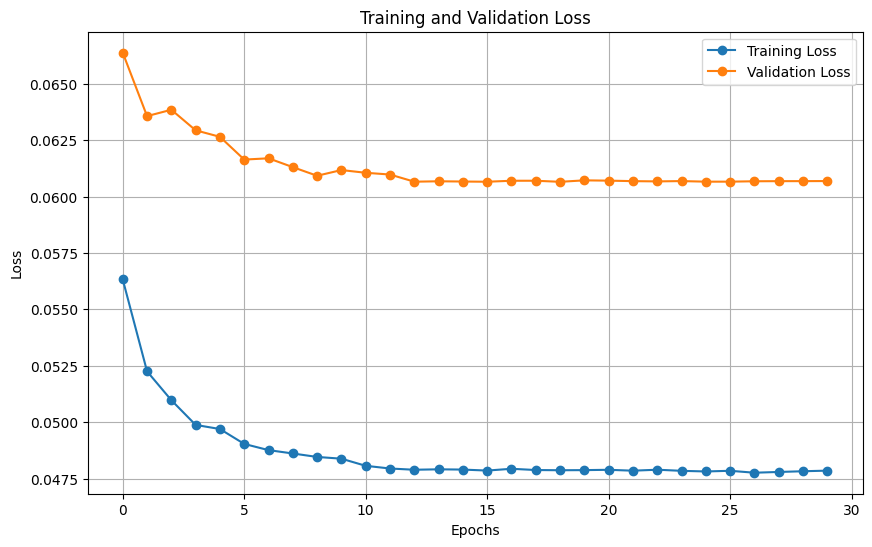

In [ ]:
torch.set_printoptions(precision=5)
finetuning_CLAP("B", epochs=30, learning_rate=1e-4, step_lr=5, gamma=0.5)

Directory '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/' already exists.


Epoch: 0 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


	Training loss: 0.05633


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


	Validation loss: 0.06589


Epoch: 1 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.05230


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


	Validation loss: 0.06393


Epoch: 2 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.05076


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


	Validation loss: 0.06323


Epoch: 3 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.05003


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06205


Epoch: 4 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04952


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06206


Epoch: 5 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04912


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


	Validation loss: 0.06174


Epoch: 6 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04858


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06218


Epoch: 7 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04843


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06173


Epoch: 8 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04827


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06159


Epoch: 9 | ---: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


	Training loss: 0.04814


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


	Validation loss: 0.06109


Epoch: 10 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04808


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06095


Epoch: 11 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04800


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06098


Epoch: 12 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04796


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06088


Epoch: 13 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06083


Epoch: 14 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04788


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06070


Epoch: 15 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04791


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


	Validation loss: 0.06067


Epoch: 16 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04785


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06066


Epoch: 17 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04781


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06065


Epoch: 18 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04791


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


	Validation loss: 0.06060


Epoch: 19 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04789


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


	Validation loss: 0.06062


Epoch: 20 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04786


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06063


Epoch: 21 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04786


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06064


Epoch: 22 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04781


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06061


Epoch: 23 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04783


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06060


Epoch: 24 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04782


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


	Validation loss: 0.06060


Epoch: 25 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04778


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06060


Epoch: 26 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04787


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


	Validation loss: 0.06062


Epoch: 27 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04784


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


	Validation loss: 0.06061


Epoch: 28 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


	Training loss: 0.04782


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06060


Epoch: 29 | ---: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


	Training loss: 0.04781


	| ---: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


	Validation loss: 0.06059


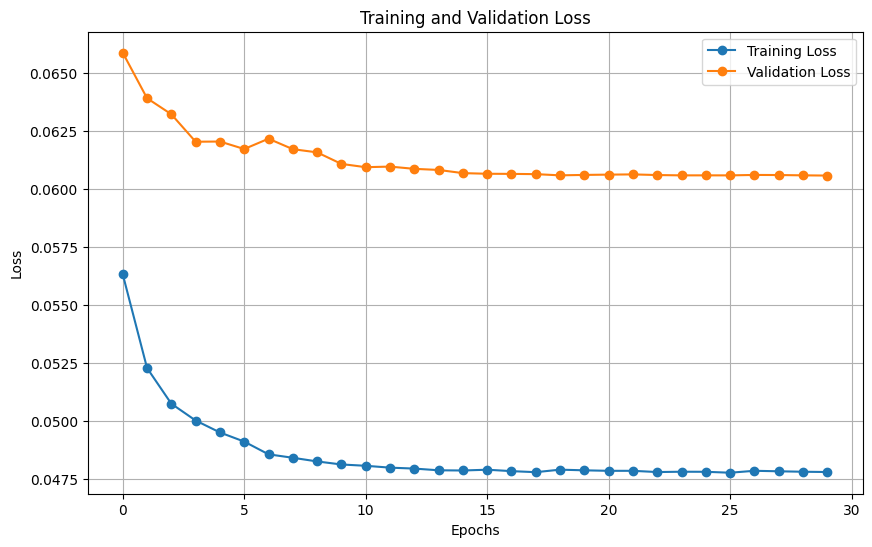

In [ ]:
torch.set_printoptions(precision=5)
finetuning_CLAP("C", epochs=30, learning_rate=1e-4, step_lr=5, gamma=0.5)

# Evaluate models

In [ ]:
from utils.eval import *
from transformers import AutoProcessor, ClapModel

In [ ]:
model = ClapModel.from_pretrained("laion/clap-htsat-unfused")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Evaluate pretrained CLAP**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"))
model = model.to(device)

In [ ]:
acc = eval_CLAP(model, "ub8k")

Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Done evaluating on ub8k. Accuracy: 71.76%


In [ ]:
acc = eval_CLAP(model, "esc50")

Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Done evaluating on esc50. Accuracy: 80.50%


In [ ]:
acc = eval_CLAP(model, "gtzan")

Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


Done evaluating on gtzan. Accuracy: 32.00%


In [ ]:
acc = eval_CLAP(model, "A")

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Done evaluating on A. Accuracy: 35.29%


In [ ]:
acc = eval_CLAP(model, "B")

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Done evaluating on B. Accuracy: 35.29%


In [ ]:
acc = eval_CLAP(model, "C")

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Done evaluating on C. Accuracy: 35.29%


In [ ]:
acc = eval_CLAP(model, "D")

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Done evaluating on D. Accuracy: 35.29%


**Evaluate CLAP finetuned on UrbanSound8k dataset**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_ub8k.pth"))
model = model.to(device)
acc = eval_CLAP(model, "ub8k")

Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Done evaluating on ub8k. Accuracy: 95.04%


**Evaluate CLAP finetuned on GTZAN dataset**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_gtzan.pth"))
model = model.to(device)
acc = eval_CLAP(model, "gtzan")

Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Done evaluating on gtzan. Accuracy: 90.00%


**Evaluate CLAP finetuned on the datasets used for the analogy**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_A.pth"))
model = model.to(device)
acc = eval_CLAP(model, "A", plot_conf_matrix=True)

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Done evaluating on A. Accuracy: 93.63%
Confusion matrix:
 [[1 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      0.67      0.80         3
           6       0.60      0.75      0.67         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       0.50      1.00      0.67         1
          11       0.50      1.00      0.67         2
          12       1.00      1.00      1.00         4
          13       1.00      0.83      0

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_B.pth"))
model = model.to(device)
acc = eval_CLAP(model, "B", plot_conf_matrix=True)

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Done evaluating on B. Accuracy: 94.12%
Confusion matrix:
 [[1 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       0.75      0.75      0.75         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       0.50      1.00      0.67         2
          12       1.00      1.00      1.00         4
          13       0.86      1.00      0

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_C.pth"))
model = model.to(device)
acc = eval_CLAP(model, "C", plot_conf_matrix=True)

Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Done evaluating on C. Accuracy: 92.65%
Confusion matrix:
 [[1 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         3
           4       0.86      1.00      0.92         6
           5       1.00      0.67      0.80         3
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       0.50      1.00      0.67         1
          11       0.50      1.00      0.67         2
          12       1.00      1.00      1.00         4
          13       0.86      1.00      0

# Task vectors

In [ ]:
import torch
from utils.task_vectors import *
from utils.eval import *
from utils.plots import *
from transformers import AutoProcessor, ClapModel

## Forgetting via negation

*ESC50* is a dataset on which the pre-trained CLAP model performs quite well. We will use this dataset for the control task. Experiments will be conducted on both the *GTZAN* and *UrbanSound8k* datasets as target tasks.

General procedure:
\begin{align}
\tau &= \theta_{pt} - \theta_{ft\_target}\\
\tau_{new} &= -\tau\\
\theta_{new} &= \theta_{pt} + \lambda\tau_{new}
\end{align}

Negating the task vectors should provide an effective strategy for decreasing accuracy on the target task while minimally impacting the control task. Let's test this approach.

In [ ]:
def forgetting_via_negation(pretrained_checkpoint, control_dataset, target_dataset):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  finetuned_checkpoint = pretrained_dir = f'/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/finetuned_{target_dataset}.pth'

  task_vector = TaskVector(pretrained_checkpoint, finetuned_checkpoint)

  # Negating a task vector
  neg_task_vector = -task_vector

  acc_control = []
  acc_target = []
  coeff = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  coeff2acc = {}

  for sc in coeff:
    print(f'\n---  Scaling coefficient: {sc}  ---')
    # Apply the task vector
    model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
    new_clap = neg_task_vector.apply_to(model, pretrained_checkpoint, scaling_coef=sc)
    new_clap = new_clap.to(device)

    # Evaluate
    acc_control = eval_CLAP(new_clap, control_dataset)
    acc_target = eval_CLAP(new_clap, target_dataset)
    coeff2acc[sc] = (acc_control, acc_target)

  print("\n--- Resume ---")
  for sc, accs in coeff2acc.items():
    print(f'alpha: {sc}  ->  acc_control: {accs[0]} ({control_dataset}) , acc_target: {accs[1]} ({target_dataset})')

  return coeff2acc

**Forgetting GTZAN**

In [ ]:
control_dataset = "esc50"
target_dataset = "gtzan"
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = forgetting_via_negation(pretrained_checkpoint, control_dataset, target_dataset)


---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]



Done evaluating on gtzan. Accuracy: 26.00%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]



Done evaluating on gtzan. Accuracy: 21.00%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]



Done evaluating on gtzan. Accuracy: 18.00%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]



Done evaluating on gtzan. Accuracy: 15.00%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]



Done evaluating on gtzan. Accuracy: 15.00%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]



Done evaluating on gtzan. Accuracy: 12.00%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Done evaluating on esc50. Accuracy: 77.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 11.00%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Done evaluating on gtzan. Accuracy: 10.00%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 10.00%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 11.00%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 68.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]



Done evaluating on gtzan. Accuracy: 11.00%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 66.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 11.00%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on esc50. Accuracy: 62.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]



Done evaluating on gtzan. Accuracy: 11.00%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 58.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]



Done evaluating on gtzan. Accuracy: 10.00%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 56.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 10.00%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 54.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 9.00%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 49.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]



Done evaluating on gtzan. Accuracy: 9.00%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on esc50. Accuracy: 46.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]



Done evaluating on gtzan. Accuracy: 9.00%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 43.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Done evaluating on gtzan. Accuracy: 8.00%

--- Resume ---
alpha: 0.1  ->  acc_control: 0.795 (esc50) , acc_target: 0.26 (gtzan)
alpha: 0.15  ->  acc_control: 0.79 (esc50) , acc_target: 0.21 (gtzan)
alpha: 0.2  ->  acc_control: 0.78 (esc50) , acc_target: 0.18 (gtzan)
alpha: 0.25  ->  acc_control: 0.785 (esc50) , acc_target: 0.15 (gtzan)
alpha: 0.3  ->  acc_control: 0.785 (esc50) , acc_target: 0.15 (gtzan)
alpha: 0.35  ->  acc_control: 0.775 (esc50) , acc_target: 0.12 (gtzan)
alpha: 0.4  ->  acc_control: 0.77 (esc50) , acc_target: 0.11 (gtzan)
alpha: 0.45  ->  acc_control: 0.765 (esc50) , acc_target: 0.1 (gtzan)
alpha: 0.5  ->  acc_control: 0.745 (esc50) , acc_target: 0.1 (gtzan)
alpha: 0.55  ->  acc_control: 0.71 (esc50) , acc_target: 0.11 (gtzan)
alpha: 0.6  ->  acc_control: 0.685 (esc50) , acc_target: 0.11 (gtzan)
alpha: 0.65  ->  acc_control: 0.66 (esc50) , acc_target: 0.11 (gtzan)
alpha: 0.7  ->  acc_control: 0.625 (esc50) , acc_target: 0.11 (gtzan)
alpha: 0.75  ->  acc_control: 0.

In [ ]:
coeff2acc

{0.1: (0.795, 0.26),
 0.15: (0.79, 0.21),
 0.2: (0.78, 0.18),
 0.25: (0.785, 0.15),
 0.3: (0.785, 0.15),
 0.35: (0.775, 0.12),
 0.4: (0.77, 0.11),
 0.45: (0.765, 0.1),
 0.5: (0.745, 0.1),
 0.55: (0.71, 0.11),
 0.6: (0.685, 0.11),
 0.65: (0.66, 0.11),
 0.7: (0.625, 0.11),
 0.75: (0.585, 0.1),
 0.8: (0.56, 0.1),
 0.85: (0.54, 0.09),
 0.9: (0.49, 0.09),
 0.95: (0.46, 0.09),
 1: (0.43, 0.08)}

In [ ]:
control_dataset = "esc50"
target_dataset = "gtzan"

coeff2acc = {0.1: (0.795, 0.26),
 0.15: (0.79, 0.21),
 0.2: (0.78, 0.18),
 0.25: (0.785, 0.15),
 0.3: (0.785, 0.15),
 0.35: (0.775, 0.12),
 0.4: (0.77, 0.11),
 0.45: (0.765, 0.1),
 0.5: (0.745, 0.1),
 0.55: (0.71, 0.11),
 0.6: (0.685, 0.11),
 0.65: (0.66, 0.11),
 0.7: (0.625, 0.11),
 0.75: (0.585, 0.1),
 0.8: (0.56, 0.1),
 0.85: (0.54, 0.09),
 0.9: (0.49, 0.09),
 0.95: (0.46, 0.09),
 1: (0.43, 0.08)}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


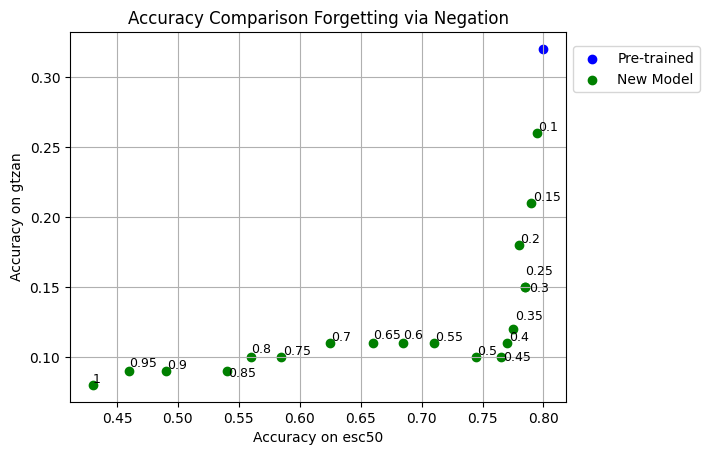

In [ ]:
acc_pt_control = 0.80   # pretrained CLAP model accuracy on esc50 dataset
acc_pt_target = 0.32   # pretrained CLAP model accuracy on gtzan dataset
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"

comparison_acc_forget(acc_pt_control, acc_pt_target, coeff2acc, control_dataset, target_dataset, dir_to_save)

The results are promising. With a scaling coefficient of 0.45, the accuracy on the target task (*GTZAN* dataset) decreased significantly to 10%, while the accuracy on the control task (*ESC50* dataset) experienced only a minor reduction of 3%, remaining largely stable.

**Forgetting UrbanSound8k**

In [ ]:
control_dataset = "esc50"
target_dataset = "ub8k"
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = forgetting_via_negation(pretrained_checkpoint, control_dataset, target_dataset)


---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]



Done evaluating on ub8k. Accuracy: 61.45%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 54.58%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Done evaluating on esc50. Accuracy: 70.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Done evaluating on ub8k. Accuracy: 50.76%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 44.27%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



Done evaluating on ub8k. Accuracy: 37.40%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 60.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]



Done evaluating on ub8k. Accuracy: 32.06%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Done evaluating on esc50. Accuracy: 58.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]



Done evaluating on ub8k. Accuracy: 28.24%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 53.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 25.57%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 51.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]



Done evaluating on ub8k. Accuracy: 21.37%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 47.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 18.32%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 41.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]



Done evaluating on ub8k. Accuracy: 16.41%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 35.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Done evaluating on ub8k. Accuracy: 14.12%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 33.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



Done evaluating on ub8k. Accuracy: 11.45%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 32.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 9.54%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 27.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Done evaluating on ub8k. Accuracy: 9.54%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 23.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 9.16%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 21.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 7.25%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on esc50. Accuracy: 18.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



Done evaluating on ub8k. Accuracy: 7.25%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Done evaluating on esc50. Accuracy: 16.50%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Done evaluating on ub8k. Accuracy: 7.25%

--- Resume ---
alpha: 0.1  ->  acc_control: 0.735 (esc50) , acc_target: 0.6145038167938931 (ub8k)
alpha: 0.15  ->  acc_control: 0.72 (esc50) , acc_target: 0.5458015267175572 (ub8k)
alpha: 0.2  ->  acc_control: 0.705 (esc50) , acc_target: 0.5076335877862596 (ub8k)
alpha: 0.25  ->  acc_control: 0.67 (esc50) , acc_target: 0.44274809160305345 (ub8k)
alpha: 0.3  ->  acc_control: 0.63 (esc50) , acc_target: 0.37404580152671757 (ub8k)
alpha: 0.35  ->  acc_control: 0.605 (esc50) , acc_target: 0.32061068702290074 (ub8k)
alpha: 0.4  ->  acc_control: 0.58 (esc50) , acc_target: 0.2824427480916031 (ub8k)
alpha: 0.45  ->  acc_control: 0.535 (esc50) , acc_target: 0.25572519083969464 (ub8k)
alpha: 0.5  ->  acc_control: 0.515 (esc50) , acc_target: 0.21374045801526717 (ub8k)
alpha: 0.55  ->  acc_control: 0.475 (esc50) , acc_target: 0.183206106870229 (ub8k)
alpha: 0.6  ->  acc_control: 0.41 (esc50) , acc_target: 0.16412213740458015 (ub8k)
alpha: 0.65  ->  acc_con

In [ ]:
coeff2acc

{0.1: (0.735, 0.6145038167938931),
 0.15: (0.72, 0.5458015267175572),
 0.2: (0.705, 0.5076335877862596),
 0.25: (0.67, 0.44274809160305345),
 0.3: (0.63, 0.37404580152671757),
 0.35: (0.605, 0.32061068702290074),
 0.4: (0.58, 0.2824427480916031),
 0.45: (0.535, 0.25572519083969464),
 0.5: (0.515, 0.21374045801526717),
 0.55: (0.475, 0.183206106870229),
 0.6: (0.41, 0.16412213740458015),
 0.65: (0.355, 0.14122137404580154),
 0.7: (0.33, 0.11450381679389313),
 0.75: (0.32, 0.09541984732824428),
 0.8: (0.275, 0.09541984732824428),
 0.85: (0.235, 0.0916030534351145),
 0.9: (0.215, 0.07251908396946564),
 0.95: (0.18, 0.07251908396946564),
 1: (0.165, 0.07251908396946564)}

In [ ]:
coeff2acc = {
 0.1: (0.735, 0.6145038167938931),
 0.15: (0.72, 0.5458015267175572),
 0.2: (0.705, 0.5076335877862596),
 0.25: (0.67, 0.44274809160305345),
 0.3: (0.63, 0.37404580152671757),
 0.35: (0.605, 0.32061068702290074),
 0.4: (0.58, 0.2824427480916031),
 0.45: (0.535, 0.25572519083969464),
 0.5: (0.515, 0.21374045801526717),
 0.55: (0.475, 0.183206106870229),
 0.6: (0.41, 0.16412213740458015),
 0.65: (0.355, 0.14122137404580154),
 0.7: (0.33, 0.11450381679389313),
 0.75: (0.32, 0.09541984732824428),
 0.8: (0.275, 0.09541984732824428),
 0.85: (0.235, 0.0916030534351145),
 0.9: (0.215, 0.07251908396946564),
 0.95: (0.18, 0.07251908396946564),
 1: (0.165, 0.07251908396946564)}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


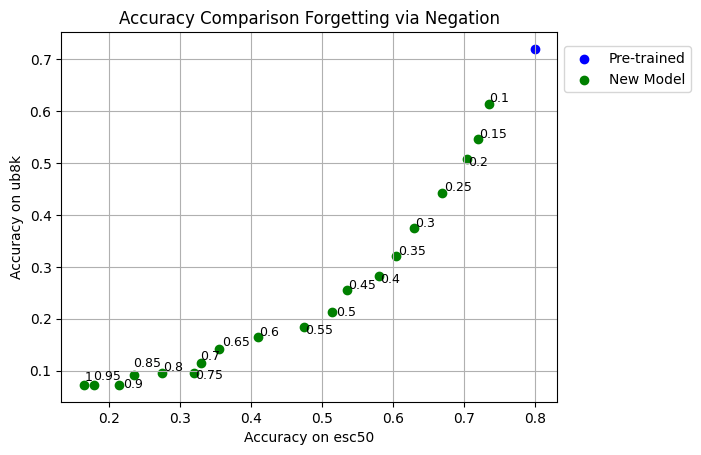

In [ ]:
control_dataset = "esc50"
target_dataset = "ub8k"
acc_pt_control = 0.80   # pretrained CLAP model accuracy on esc50 dataset
acc_pt_target = 0.72   # pretrained CLAP model accuracy on urbanSound8k dataset
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"

comparison_acc_forget(acc_pt_control, acc_pt_target, coeff2acc, control_dataset, target_dataset, dir_to_save)

The results are considerably worse compared to the experiments conducted on the *GTZAN* dataset. Although the control (*ESC50* ) and target (*UrbanSound8k*) datasets differ in scope and focus, there is some overlap in the classes related to common urban and animal sounds.\
Decreases in the accuracy of the target dataset lead to notable, even if not dramatic, reductions in the accuracy of the control dataset.

## Learning via addition

Experiments will be conducted on both the *GTZAN* and *UrbanSound8k* datasets. Let's try to build a multi-task model that are proficient on multiple tasks simultaneously.

General procedure:
\begin{align}
\tau_1 &= \theta_{pt} - \theta_{ft\_task_1}\\
\tau_2 &= \theta_{pt} - \theta_{ft\_task_2}\\
\tau_{new} &= \tau_1 + \tau_2\\
\theta_{new} &= \theta_{pt} + \lambda\tau_{new}
\end{align}

In [ ]:
def learning_via_addition(pretrained_checkpoint, finetuned_datasets):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  finetuned_dir = pretrained_dir = "/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/"

  finetuned_checkpoints = [finetuned_dir+f'finetuned_{ds}.pth' for ds in finetuned_datasets]
  print(finetuned_checkpoints)

  task_vectors = [
    TaskVector(pretrained_checkpoint, finetuned_checkpoint)
    for finetuned_checkpoint in finetuned_checkpoints]

  # Sum the task vectors
  task_vector_sum = sum(task_vectors)
  coeff = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  coeff2acc = {}
  for sc in coeff:
    print(f'\n---  Scaling coefficient: {sc}  ---')
    # Apply the task vector
    model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
    new_clap = task_vector_sum.apply_to(model, pretrained_checkpoint, scaling_coef=sc)
    new_clap = new_clap.to(device)

    # Evaluate
    acc = eval_CLAP(new_clap, "esc50")
    acc_1 = eval_CLAP(new_clap, finetuned_datasets[0])
    acc_2 = eval_CLAP(new_clap, finetuned_datasets[1])
    coeff2acc[sc] = (acc_1, acc_2)

  print("\n--- Resume ---")
  for sc, accs in coeff2acc.items():
    print(f'alpha: {sc} -> {accs[0]} ({finetuned_datasets[0]}) , {accs[1]} ({finetuned_datasets[1]})')

  return coeff2acc

In [ ]:
datasets_name = ["gtzan", "ub8k"]
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = learning_via_addition(pretrained_checkpoint, datasets_name)

['/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_gtzan.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_ub8k.pth']

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]



Done evaluating on gtzan. Accuracy: 44.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]



Done evaluating on ub8k. Accuracy: 81.30%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]



Done evaluating on ub8k. Accuracy: 81.68%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]



Done evaluating on gtzan. Accuracy: 60.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



Done evaluating on ub8k. Accuracy: 87.02%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]



Done evaluating on gtzan. Accuracy: 63.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]



Done evaluating on gtzan. Accuracy: 69.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]



Done evaluating on esc50. Accuracy: 59.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 54.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Done evaluating on esc50. Accuracy: 51.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Done evaluating on ub8k. Accuracy: 90.46%

--- Resume ---
alpha:  0.1  ->  0.44  (gtzan) ,  0.8129770992366412  (ub8k)
alpha:  0.15  ->  0.49  (gtzan) ,  0.816793893129771  (ub8k)
alpha:  0.2  ->  0.56  (gtzan) ,  0.8587786259541985  (ub8k)
alpha:  0.25  ->  0.6  (gtzan) ,  0.8702290076335878  (ub8k)
alpha:  0.3  ->  0.63  (gtzan) ,  0.8893129770992366  (ub8k)
alpha:  0.35  ->  0.67  (gtzan) ,  0.9007633587786259  (ub8k)
alpha:  0.4  ->  0.69  (gtzan) ,  0.9083969465648855  (ub8k)
alpha:  0.45  ->  0.72  (gtzan) ,  0.9122137404580153  (ub8k)
alpha:  0.5  ->  0.73  (gtzan) ,  0.9198473282442748  (ub8k)
alpha:  0.55  ->  0.74  (gtzan) ,  0.9122137404580153  (ub8k)
alpha:  0.6  ->  0.74  (gtzan) ,  0.916030534351145  (ub8k)
alpha:  0.65  ->  0.76  (gtzan) ,  0.9236641221374046  (ub8k)
alpha:  0.7  ->  0.76  (gtzan) ,  0.9198473282442748  (ub8k)
alpha:  0.75  ->  0.75  (gtzan) ,  0.9198473282442748  (ub8k)
alpha:  0.8  ->  0.75  (gtzan) ,  0.916030534351145  (ub8k)
alpha:  0.85  ->  0.75 

In [ ]:
coeff2acc

{0.1: (0.44, 0.8129770992366412),
 0.15: (0.49, 0.816793893129771),
 0.2: (0.56, 0.8587786259541985),
 0.25: (0.6, 0.8702290076335878),
 0.3: (0.63, 0.8893129770992366),
 0.35: (0.67, 0.9007633587786259),
 0.4: (0.69, 0.9083969465648855),
 0.45: (0.72, 0.9122137404580153),
 0.5: (0.73, 0.9198473282442748),
 0.55: (0.74, 0.9122137404580153),
 0.6: (0.74, 0.916030534351145),
 0.65: (0.76, 0.9236641221374046),
 0.7: (0.76, 0.9198473282442748),
 0.75: (0.75, 0.9198473282442748),
 0.8: (0.75, 0.916030534351145),
 0.85: (0.75, 0.9122137404580153),
 0.9: (0.74, 0.9045801526717557),
 0.95: (0.74, 0.9045801526717557),
 1: (0.73, 0.9045801526717557)}

In [ ]:
datasets_name = ["gtzan", "ub8k"]
coeff2acc = {0.1: (0.44, 0.8129770992366412),
 0.15: (0.49, 0.816793893129771),
 0.2: (0.56, 0.8587786259541985),
 0.25: (0.6, 0.8702290076335878),
 0.3: (0.63, 0.8893129770992366),
 0.35: (0.67, 0.9007633587786259),
 0.4: (0.69, 0.9083969465648855),
 0.45: (0.72, 0.9122137404580153),
 0.5: (0.73, 0.9198473282442748),
 0.55: (0.74, 0.9122137404580153),
 0.6: (0.74, 0.916030534351145),
 0.65: (0.76, 0.9236641221374046),
 0.7: (0.76, 0.9198473282442748),
 0.75: (0.75, 0.9198473282442748),
 0.8: (0.75, 0.916030534351145),
 0.85: (0.75, 0.9122137404580153),
 0.9: (0.74, 0.9045801526717557),
 0.95: (0.74, 0.9045801526717557),
 1: (0.73, 0.9045801526717557)}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


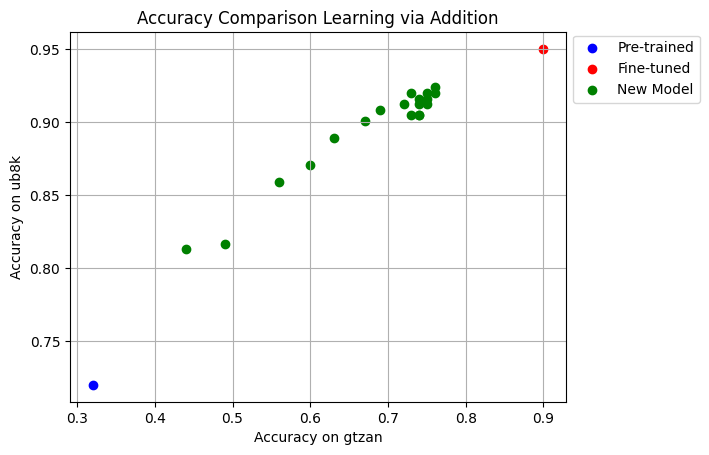

In [ ]:
acc_pretrained_1 = 0.32   # pretrained CLAP model accuracy on gtzan dataset
acc_pretrained_2 = 0.72   # pretrained CLAP model accuracy on ub8k dataset
acc_finetuned_1 = 0.90    # finetuned CLAP model accuracy on gtzan dataset
acc_finetuned_2 = 0.95    # finetuned CLAP model accuracy on ub8k dataset
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"

comparison_acc_learning(acc_pretrained_1, acc_pretrained_2, acc_finetuned_1, acc_finetuned_2, coeff2acc, datasets_name[0], datasets_name[1], dir_to_save, norm=False)

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


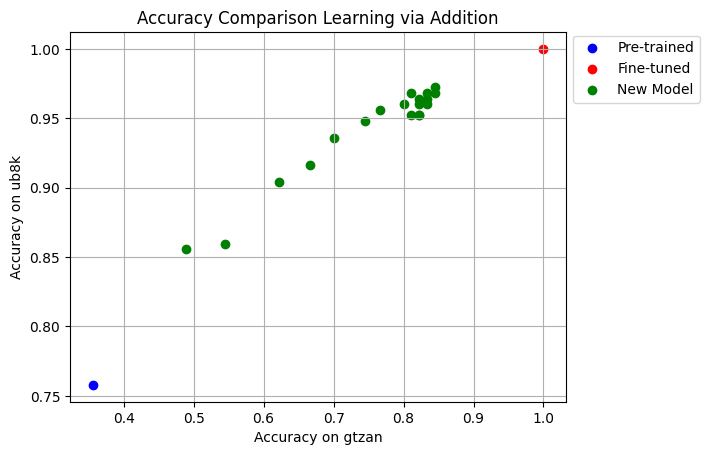

In [ ]:
comparison_acc_learning(acc_pretrained_1, acc_pretrained_2, acc_finetuned_1, acc_finetuned_2, coeff2acc, datasets_name[0], datasets_name[1], dir_to_save, norm=True)

The results did not meet expectations. The new model struggles to perform well on both tasks. While the accuracy on *UrbanSound8k* is good, the performance on *GTZAN* are not even close to the finetuned checkpoint.

Let's try using **two different scaling coefficients**, one for each task vector:
\begin{align}
\tau_1 &= \theta_{pt} - \theta_{ft\_task_1}\\
\tau_2 &= \theta_{pt} - \theta_{ft\_task_2}\\
\tau_{new} &= \alpha\tau_1 + \beta\tau_2\\
\theta_{new} &= \theta_{pt} + \tau_{new}
\end{align}

In [ ]:
def learning_via_addition_2sc(pretrained_checkpoint, finetuned_datasets):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  finetuned_dir = pretrained_dir = "/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/"

  finetuned_checkpoints = [finetuned_dir+f'finetuned_{ds}.pth' for ds in finetuned_datasets]
  print(finetuned_checkpoints)

  task_vectors = [
    TaskVector(pretrained_checkpoint, finetuned_checkpoint)
    for finetuned_checkpoint in finetuned_checkpoints]

  coeff = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  coeff2acc = {}
  for sc in coeff:
    for sc_b in coeff:

      # Sum the task vectors
      task_vector_sum = sc*task_vectors[0] + sc_b*task_vectors[1]

      print(f'\n---  Scaling coefficient: {sc}  ---')
      # Apply the task vector
      model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
      new_clap = task_vector_sum.apply_to(model, pretrained_checkpoint, scaling_coef=1)#sc)
      new_clap = new_clap.to(device)

      # Evaluate
      acc = eval_CLAP(new_clap, "esc50")
      acc_1 = eval_CLAP(new_clap, finetuned_datasets[0])
      acc_2 = eval_CLAP(new_clap, finetuned_datasets[1])
      coeff2acc[(sc, sc_b)] = (acc_1, acc_2)

  print("\n--- Resume ---")
  for (sc, sc_b), accs in coeff2acc.items():
    print(f'alphas: ({sc}, {sc_b}) -> {accs[0]} ({finetuned_datasets[0]}) , {accs[1]} ({finetuned_datasets[1]})')

  return coeff2acc

In [ ]:
datasets_name = ["gtzan", "ub8k"]
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = learning_via_addition_2sc(pretrained_checkpoint, datasets_name)

['/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_gtzan.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_ub8k.pth']

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



Done evaluating on gtzan. Accuracy: 44.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 81.30%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Done evaluating on gtzan. Accuracy: 45.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



Done evaluating on ub8k. Accuracy: 82.44%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]



Done evaluating on esc50. Accuracy: 80.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 43.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 87.79%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 80.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 42.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 88.55%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 37.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]



Done evaluating on gtzan. Accuracy: 35.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]



Done evaluating on esc50. Accuracy: 80.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]



Done evaluating on gtzan. Accuracy: 33.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 33.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]



Done evaluating on gtzan. Accuracy: 31.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 30.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 28.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 28.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.80%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 71.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 25.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.80%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 24.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 68.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 22.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 65.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 22.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 62.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 21.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 21.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 53.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 81.30%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 81.68%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 50.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 87.02%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 80.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 88.55%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 47.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 44.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 40.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 37.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 38.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 35.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 32.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.80%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.80%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 70.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 27.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 26.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 63.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 23.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 61.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 23.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.15  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 59.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 23.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 80.15%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 60.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 81.68%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 53.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 50.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 47.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 46.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 44.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 41.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 37.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 34.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 32.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 71.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 31.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 70.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 30.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 63.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 28.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 60.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 24.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 58.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 23.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 66.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 78.63%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 63.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 85.50%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 60.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 87.02%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 54.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 52.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 48.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 45.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 40.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 35.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 71.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 34.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 69.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 33.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 32.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 30.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 29.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.25  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 57.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 28.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 71.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 79.39%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 69.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 85.11%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 66.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 87.40%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 63.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 80.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 50.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 45.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 42.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 38.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 68.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 36.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 65.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 35.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 62.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 33.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.42%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 59.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 31.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 56.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 30.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



Done evaluating on ub8k. Accuracy: 79.01%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 82.06%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]



Done evaluating on gtzan. Accuracy: 71.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 89.31%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 60.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 54.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]



Done evaluating on gtzan. Accuracy: 54.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 43.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 68.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 40.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 64.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 38.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 62.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 36.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 58.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 35.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 55.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 32.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 95.04%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 77.86%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 83.97%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 71.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 69.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 62.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 77.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 55.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Done evaluating on gtzan. Accuracy: 52.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 47.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 64.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]



Done evaluating on gtzan. Accuracy: 41.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 61.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 38.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 57.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



Done evaluating on gtzan. Accuracy: 38.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]



Done evaluating on ub8k. Accuracy: 94.27%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 55.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 36.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 94.66%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]



Done evaluating on ub8k. Accuracy: 78.24%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 82.06%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 85.11%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 80.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 68.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]



Done evaluating on gtzan. Accuracy: 62.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 70.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]



Done evaluating on gtzan. Accuracy: 52.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 64.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 49.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]



Done evaluating on gtzan. Accuracy: 46.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 58.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Done evaluating on gtzan. Accuracy: 43.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 55.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Done evaluating on gtzan. Accuracy: 39.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 76.34%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]



Done evaluating on ub8k. Accuracy: 81.30%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 83.59%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]



Done evaluating on ub8k. Accuracy: 87.02%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]



Done evaluating on gtzan. Accuracy: 69.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Done evaluating on gtzan. Accuracy: 66.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 63.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]



Done evaluating on gtzan. Accuracy: 62.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 69.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 57.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 63.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 52.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]



Done evaluating on gtzan. Accuracy: 48.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]



Done evaluating on esc50. Accuracy: 58.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]



Done evaluating on gtzan. Accuracy: 46.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]



Done evaluating on ub8k. Accuracy: 93.89%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]



Done evaluating on esc50. Accuracy: 54.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 46.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



Done evaluating on ub8k. Accuracy: 76.34%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 79.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 81.30%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 83.97%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



Done evaluating on ub8k. Accuracy: 85.50%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 77.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 65.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 69.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 62.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 63.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 53.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 58.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 50.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 53.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 48.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 77.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



Done evaluating on ub8k. Accuracy: 75.19%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 79.77%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 83.21%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



Done evaluating on ub8k. Accuracy: 85.11%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 87.79%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 66.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 69.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 66.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 60.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 59.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 57.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 53.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 53.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 75.19%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 78.63%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 79.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 83.97%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 70.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 68.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 62.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 56.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 93.51%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 53.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 56.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 74.05%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 77.10%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 80.53%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 78.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 85.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 68.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 71.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 64.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 69.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 68.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 57.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 53.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 61.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 72.52%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 75.57%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 80.53%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 77.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 81.68%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 77.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 85.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 84.73%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 85.50%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 87.40%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 67.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 66.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 72.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 63.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 92.75%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 68.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 93.13%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 57.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 92.37%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 53.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 62.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 70.23%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 72.90%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 76.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 79.77%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 76.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 81.68%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 85.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 87.79%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 89.31%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 70.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 79.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 59.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 56.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 54.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 64.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.98%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 68.32%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



Done evaluating on ub8k. Accuracy: 70.99%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 77.86%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 80.92%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 83.97%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 85.11%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 87.40%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 88.17%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 89.31%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 71.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 70.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 63.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 75.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 59.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 71.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 55.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 91.60%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 53.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 65.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



Done evaluating on ub8k. Accuracy: 91.22%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 65.27%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 69.47%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 75.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 75.19%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 79.01%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 82.44%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 84.73%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 85.88%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 87.02%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 87.79%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 88.55%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 68.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 65.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 62.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 59.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 55.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 52.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 67.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 90.84%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 62.21%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 66.41%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 71.37%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 76.72%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 80.15%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 83.21%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 85.50%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 85.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 72.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 83.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 87.79%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 70.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 88.93%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 68.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 66.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 64.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 61.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Done evaluating on esc50. Accuracy: 60.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 76.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Done evaluating on esc50. Accuracy: 54.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 51.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 70.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.46%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 90.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 60.31%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



Done evaluating on ub8k. Accuracy: 64.89%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 74.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 68.32%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 74.05%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 73.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 77.48%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]



Done evaluating on esc50. Accuracy: 75.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 87.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 82.82%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 88.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 83.21%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 74.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



Done evaluating on gtzan. Accuracy: 86.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 84.35%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



Done evaluating on esc50. Accuracy: 73.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 85.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Done evaluating on esc50. Accuracy: 72.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



Done evaluating on esc50. Accuracy: 71.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]



Done evaluating on gtzan. Accuracy: 84.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 86.26%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 70.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 82.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Done evaluating on ub8k. Accuracy: 86.64%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on esc50. Accuracy: 67.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Done evaluating on gtzan. Accuracy: 80.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]



Done evaluating on ub8k. Accuracy: 89.31%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 66.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]



Done evaluating on gtzan. Accuracy: 81.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 89.31%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on esc50. Accuracy: 64.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Done evaluating on gtzan. Accuracy: 78.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 61.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]



Done evaluating on esc50. Accuracy: 59.50%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 77.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]



Done evaluating on ub8k. Accuracy: 89.69%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 54.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Done evaluating on gtzan. Accuracy: 74.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]



Done evaluating on ub8k. Accuracy: 90.08%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Done evaluating on esc50. Accuracy: 51.00%


Test --- : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Done evaluating on gtzan. Accuracy: 73.00%


Test --- : 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Done evaluating on ub8k. Accuracy: 90.46%

--- Resume ---
alphas: (0.1, 0.1) -> 0.44 (gtzan) , 0.8129770992366412 (ub8k)
alphas: (0.1, 0.15) -> 0.45 (gtzan) , 0.8244274809160306 (ub8k)
alphas: (0.1, 0.2) -> 0.43 (gtzan) , 0.8778625954198473 (ub8k)
alphas: (0.1, 0.25) -> 0.42 (gtzan) , 0.8854961832061069 (ub8k)
alphas: (0.1, 0.3) -> 0.37 (gtzan) , 0.9083969465648855 (ub8k)
alphas: (0.1, 0.35) -> 0.35 (gtzan) , 0.9236641221374046 (ub8k)
alphas: (0.1, 0.4) -> 0.33 (gtzan) , 0.9236641221374046 (ub8k)
alphas: (0.1, 0.45) -> 0.33 (gtzan) , 0.9236641221374046 (ub8k)
alphas: (0.1, 0.5) -> 0.31 (gtzan) , 0.9351145038167938 (ub8k)
alphas: (0.1, 0.55) -> 0.29 (gtzan) , 0.9389312977099237 (ub8k)
alphas: (0.1, 0.6) -> 0.3 (gtzan) , 0.9465648854961832 (ub8k)
alphas: (0.1, 0.65) -> 0.28 (gtzan) , 0.950381679389313 (ub8k)
alphas: (0.1, 0.7) -> 0.28 (gtzan) , 0.9580152671755725 (ub8k)
alphas: (0.1, 0.75) -> 0.25 (gtzan) , 0.9580152671755725 (ub8k)
alphas: (0.1, 0.8) -> 0.24 (gtzan) , 0.954198473282442

In [ ]:
coeff2acc

{(0.1, 0.1): (0.44, 0.8129770992366412),
 (0.1, 0.15): (0.45, 0.8244274809160306),
 (0.1, 0.2): (0.43, 0.8778625954198473),
 (0.1, 0.25): (0.42, 0.8854961832061069),
 (0.1, 0.3): (0.37, 0.9083969465648855),
 (0.1, 0.35): (0.35, 0.9236641221374046),
 (0.1, 0.4): (0.33, 0.9236641221374046),
 (0.1, 0.45): (0.33, 0.9236641221374046),
 (0.1, 0.5): (0.31, 0.9351145038167938),
 (0.1, 0.55): (0.29, 0.9389312977099237),
 (0.1, 0.6): (0.3, 0.9465648854961832),
 (0.1, 0.65): (0.28, 0.950381679389313),
 (0.1, 0.7): (0.28, 0.9580152671755725),
 (0.1, 0.75): (0.25, 0.9580152671755725),
 (0.1, 0.8): (0.24, 0.9541984732824428),
 (0.1, 0.85): (0.22, 0.950381679389313),
 (0.1, 0.9): (0.22, 0.950381679389313),
 (0.1, 0.95): (0.21, 0.950381679389313),
 (0.1, 1): (0.21, 0.9465648854961832),
 (0.15, 0.1): (0.53, 0.8129770992366412),
 (0.15, 0.15): (0.49, 0.816793893129771),
 (0.15, 0.2): (0.5, 0.8702290076335878),
 (0.15, 0.25): (0.49, 0.8854961832061069),
 (0.15, 0.3): (0.47, 0.9045801526717557),
 (0.15, 0

In [ ]:
datasets_name = ["gtzan", "ub8k"]
coeff2acc = {
 (0.1, 0.1): (0.44, 0.8129770992366412),
 (0.1, 0.15): (0.45, 0.8244274809160306),
 (0.1, 0.2): (0.43, 0.8778625954198473),
 (0.1, 0.25): (0.42, 0.8854961832061069),
 (0.1, 0.3): (0.37, 0.9083969465648855),
 (0.1, 0.35): (0.35, 0.9236641221374046),
 (0.1, 0.4): (0.33, 0.9236641221374046),
 (0.1, 0.45): (0.33, 0.9236641221374046),
 (0.1, 0.5): (0.31, 0.9351145038167938),
 (0.1, 0.55): (0.29, 0.9389312977099237),
 (0.1, 0.6): (0.3, 0.9465648854961832),
 (0.1, 0.65): (0.28, 0.950381679389313),
 (0.1, 0.7): (0.28, 0.9580152671755725),
 (0.1, 0.75): (0.25, 0.9580152671755725),
 (0.1, 0.8): (0.24, 0.9541984732824428),
 (0.1, 0.85): (0.22, 0.950381679389313),
 (0.1, 0.9): (0.22, 0.950381679389313),
 (0.1, 0.95): (0.21, 0.950381679389313),
 (0.1, 1): (0.21, 0.9465648854961832),
 (0.15, 0.1): (0.53, 0.8129770992366412),
 (0.15, 0.15): (0.49, 0.816793893129771),
 (0.15, 0.2): (0.5, 0.8702290076335878),
 (0.15, 0.25): (0.49, 0.8854961832061069),
 (0.15, 0.3): (0.47, 0.9045801526717557),
 (0.15, 0.35): (0.44, 0.9236641221374046),
 (0.15, 0.4): (0.4, 0.9236641221374046),
 (0.15, 0.45): (0.37, 0.9198473282442748),
 (0.15, 0.5): (0.38, 0.9351145038167938),
 (0.15, 0.55): (0.35, 0.9312977099236641),
 (0.15, 0.6): (0.32, 0.9389312977099237),
 (0.15, 0.65): (0.29, 0.950381679389313),
 (0.15, 0.7): (0.29, 0.9580152671755725),
 (0.15, 0.75): (0.29, 0.9580152671755725),
 (0.15, 0.8): (0.27, 0.9541984732824428),
 (0.15, 0.85): (0.26, 0.9541984732824428),
 (0.15, 0.9): (0.23, 0.950381679389313),
 (0.15, 0.95): (0.23, 0.950381679389313),
 (0.15, 1): (0.23, 0.9465648854961832),
 (0.2, 0.1): (0.59, 0.8015267175572519),
 (0.2, 0.15): (0.6, 0.816793893129771),
 (0.2, 0.2): (0.56, 0.8587786259541985),
 (0.2, 0.25): (0.55, 0.8816793893129771),
 (0.2, 0.3): (0.53, 0.8969465648854962),
 (0.2, 0.35): (0.5, 0.916030534351145),
 (0.2, 0.4): (0.47, 0.9198473282442748),
 (0.2, 0.45): (0.46, 0.9122137404580153),
 (0.2, 0.5): (0.44, 0.9312977099236641),
 (0.2, 0.55): (0.41, 0.9312977099236641),
 (0.2, 0.6): (0.37, 0.9427480916030534),
 (0.2, 0.65): (0.34, 0.9465648854961832),
 (0.2, 0.7): (0.32, 0.9541984732824428),
 (0.2, 0.75): (0.31, 0.950381679389313),
 (0.2, 0.8): (0.3, 0.9541984732824428),
 (0.2, 0.85): (0.29, 0.9541984732824428),
 (0.2, 0.9): (0.28, 0.9541984732824428),
 (0.2, 0.95): (0.24, 0.950381679389313),
 (0.2, 1): (0.23, 0.9465648854961832),
 (0.25, 0.1): (0.66, 0.7862595419847328),
 (0.25, 0.15): (0.63, 0.8282442748091603),
 (0.25, 0.2): (0.61, 0.8549618320610687),
 (0.25, 0.25): (0.6, 0.8702290076335878),
 (0.25, 0.3): (0.59, 0.8969465648854962),
 (0.25, 0.35): (0.57, 0.916030534351145),
 (0.25, 0.4): (0.54, 0.9122137404580153),
 (0.25, 0.45): (0.52, 0.9122137404580153),
 (0.25, 0.5): (0.49, 0.9198473282442748),
 (0.25, 0.55): (0.48, 0.9312977099236641),
 (0.25, 0.6): (0.45, 0.9351145038167938),
 (0.25, 0.65): (0.4, 0.950381679389313),
 (0.25, 0.7): (0.35, 0.950381679389313),
 (0.25, 0.75): (0.34, 0.950381679389313),
 (0.25, 0.8): (0.33, 0.950381679389313),
 (0.25, 0.85): (0.32, 0.9541984732824428),
 (0.25, 0.9): (0.3, 0.9541984732824428),
 (0.25, 0.95): (0.29, 0.950381679389313),
 (0.25, 1): (0.28, 0.9465648854961832),
 (0.3, 0.1): (0.71, 0.7938931297709924),
 (0.3, 0.15): (0.7, 0.8282442748091603),
 (0.3, 0.2): (0.69, 0.851145038167939),
 (0.3, 0.25): (0.66, 0.8740458015267175),
 (0.3, 0.3): (0.63, 0.8893129770992366),
 (0.3, 0.35): (0.61, 0.9083969465648855),
 (0.3, 0.4): (0.57, 0.9122137404580153),
 (0.3, 0.45): (0.55, 0.9083969465648855),
 (0.3, 0.5): (0.55, 0.9198473282442748),
 (0.3, 0.55): (0.55, 0.9236641221374046),
 (0.3, 0.6): (0.5, 0.9427480916030534),
 (0.3, 0.65): (0.45, 0.9465648854961832),
 (0.3, 0.7): (0.42, 0.9465648854961832),
 (0.3, 0.75): (0.38, 0.9465648854961832),
 (0.3, 0.8): (0.36, 0.950381679389313),
 (0.3, 0.85): (0.35, 0.950381679389313),
 (0.3, 0.9): (0.33, 0.9541984732824428),
 (0.3, 0.95): (0.31, 0.950381679389313),
 (0.3, 1): (0.3, 0.9465648854961832),
 (0.35, 0.1): (0.72, 0.7900763358778626),
 (0.35, 0.15): (0.73, 0.8206106870229007),
 (0.35, 0.2): (0.72, 0.8435114503816794),
 (0.35, 0.25): (0.71, 0.8664122137404581),
 (0.35, 0.3): (0.67, 0.8931297709923665),
 (0.35, 0.35): (0.67, 0.9007633587786259),
 (0.35, 0.4): (0.61, 0.9083969465648855),
 (0.35, 0.45): (0.6, 0.9083969465648855),
 (0.35, 0.5): (0.57, 0.9122137404580153),
 (0.35, 0.55): (0.56, 0.9274809160305344),
 (0.35, 0.6): (0.54, 0.9389312977099237),
 (0.35, 0.65): (0.54, 0.9427480916030534),
 (0.35, 0.7): (0.49, 0.9427480916030534),
 (0.35, 0.75): (0.43, 0.9465648854961832),
 (0.35, 0.8): (0.4, 0.9465648854961832),
 (0.35, 0.85): (0.38, 0.950381679389313),
 (0.35, 0.9): (0.36, 0.9465648854961832),
 (0.35, 0.95): (0.35, 0.950381679389313),
 (0.35, 1): (0.32, 0.950381679389313),
 (0.4, 0.1): (0.77, 0.7786259541984732),
 (0.4, 0.15): (0.75, 0.8282442748091603),
 (0.4, 0.2): (0.75, 0.8396946564885496),
 (0.4, 0.25): (0.74, 0.8625954198473282),
 (0.4, 0.3): (0.74, 0.8816793893129771),
 (0.4, 0.35): (0.71, 0.8969465648854962),
 (0.4, 0.4): (0.69, 0.9083969465648855),
 (0.4, 0.45): (0.67, 0.9045801526717557),
 (0.4, 0.5): (0.62, 0.9122137404580153),
 (0.4, 0.55): (0.59, 0.9312977099236641),
 (0.4, 0.6): (0.55, 0.9312977099236641),
 (0.4, 0.65): (0.56, 0.9389312977099237),
 (0.4, 0.7): (0.55, 0.9351145038167938),
 (0.4, 0.75): (0.52, 0.9389312977099237),
 (0.4, 0.8): (0.47, 0.9427480916030534),
 (0.4, 0.85): (0.41, 0.9389312977099237),
 (0.4, 0.9): (0.38, 0.9427480916030534),
 (0.4, 0.95): (0.38, 0.9427480916030534),
 (0.4, 1): (0.36, 0.9465648854961832),
 (0.45, 0.1): (0.81, 0.7824427480916031),
 (0.45, 0.15): (0.81, 0.8206106870229007),
 (0.45, 0.2): (0.78, 0.851145038167939),
 (0.45, 0.25): (0.77, 0.8664122137404581),
 (0.45, 0.3): (0.76, 0.8816793893129771),
 (0.45, 0.35): (0.76, 0.8893129770992366),
 (0.45, 0.4): (0.73, 0.9083969465648855),
 (0.45, 0.45): (0.72, 0.9122137404580153),
 (0.45, 0.5): (0.68, 0.9122137404580153),
 (0.45, 0.55): (0.62, 0.9312977099236641),
 (0.45, 0.6): (0.61, 0.9236641221374046),
 (0.45, 0.65): (0.57, 0.9312977099236641),
 (0.45, 0.7): (0.57, 0.9351145038167938),
 (0.45, 0.75): (0.57, 0.9351145038167938),
 (0.45, 0.8): (0.52, 0.9351145038167938),
 (0.45, 0.85): (0.49, 0.9351145038167938),
 (0.45, 0.9): (0.46, 0.9351145038167938),
 (0.45, 0.95): (0.43, 0.9389312977099237),
 (0.45, 1): (0.39, 0.9351145038167938),
 (0.5, 0.1): (0.83, 0.7633587786259542),
 (0.5, 0.15): (0.83, 0.8129770992366412),
 (0.5, 0.2): (0.82, 0.8358778625954199),
 (0.5, 0.25): (0.8, 0.8587786259541985),
 (0.5, 0.3): (0.77, 0.8702290076335878),
 (0.5, 0.35): (0.77, 0.8893129770992366),
 (0.5, 0.4): (0.77, 0.9083969465648855),
 (0.5, 0.45): (0.75, 0.9122137404580153),
 (0.5, 0.5): (0.73, 0.9198473282442748),
 (0.5, 0.55): (0.69, 0.9122137404580153),
 (0.5, 0.6): (0.66, 0.9236641221374046),
 (0.5, 0.65): (0.63, 0.9274809160305344),
 (0.5, 0.7): (0.62, 0.9351145038167938),
 (0.5, 0.75): (0.59, 0.9351145038167938),
 (0.5, 0.8): (0.57, 0.9312977099236641),
 (0.5, 0.85): (0.52, 0.9351145038167938),
 (0.5, 0.9): (0.48, 0.9351145038167938),
 (0.5, 0.95): (0.46, 0.9389312977099237),
 (0.5, 1): (0.46, 0.9312977099236641),
 (0.55, 0.1): (0.84, 0.7633587786259542),
 (0.55, 0.15): (0.83, 0.8129770992366412),
 (0.55, 0.2): (0.82, 0.8396946564885496),
 (0.55, 0.25): (0.79, 0.8549618320610687),
 (0.55, 0.3): (0.8, 0.8625954198473282),
 (0.55, 0.35): (0.79, 0.8816793893129771),
 (0.55, 0.4): (0.78, 0.9045801526717557),
 (0.55, 0.45): (0.78, 0.9122137404580153),
 (0.55, 0.5): (0.75, 0.9083969465648855),
 (0.55, 0.55): (0.74, 0.9122137404580153),
 (0.55, 0.6): (0.72, 0.9198473282442748),
 (0.55, 0.65): (0.64, 0.9236641221374046),
 (0.55, 0.7): (0.65, 0.9312977099236641),
 (0.55, 0.75): (0.64, 0.9312977099236641),
 (0.55, 0.8): (0.62, 0.9312977099236641),
 (0.55, 0.85): (0.59, 0.9312977099236641),
 (0.55, 0.9): (0.53, 0.9351145038167938),
 (0.55, 0.95): (0.5, 0.9312977099236641),
 (0.55, 1): (0.48, 0.9351145038167938),
 (0.6, 0.1): (0.86, 0.7519083969465649),
 (0.6, 0.15): (0.86, 0.7977099236641222),
 (0.6, 0.2): (0.83, 0.8320610687022901),
 (0.6, 0.25): (0.82, 0.851145038167939),
 (0.6, 0.3): (0.79, 0.8587786259541985),
 (0.6, 0.35): (0.8, 0.8778625954198473),
 (0.6, 0.4): (0.79, 0.9007633587786259),
 (0.6, 0.45): (0.79, 0.9083969465648855),
 (0.6, 0.5): (0.78, 0.9083969465648855),
 (0.6, 0.55): (0.76, 0.9122137404580153),
 (0.6, 0.6): (0.74, 0.916030534351145),
 (0.6, 0.65): (0.74, 0.9198473282442748),
 (0.6, 0.7): (0.66, 0.9236641221374046),
 (0.6, 0.75): (0.67, 0.9274809160305344),
 (0.6, 0.8): (0.66, 0.9312977099236641),
 (0.6, 0.85): (0.64, 0.9312977099236641),
 (0.6, 0.9): (0.59, 0.9351145038167938),
 (0.6, 0.95): (0.56, 0.9351145038167938),
 (0.6, 1): (0.53, 0.9312977099236641),
 (0.65, 0.1): (0.86, 0.7519083969465649),
 (0.65, 0.15): (0.87, 0.7862595419847328),
 (0.65, 0.2): (0.87, 0.8282442748091603),
 (0.65, 0.25): (0.84, 0.8396946564885496),
 (0.65, 0.3): (0.82, 0.8587786259541985),
 (0.65, 0.35): (0.81, 0.8587786259541985),
 (0.65, 0.4): (0.8, 0.8816793893129771),
 (0.65, 0.45): (0.8, 0.9083969465648855),
 (0.65, 0.5): (0.79, 0.9083969465648855),
 (0.65, 0.55): (0.79, 0.9122137404580153),
 (0.65, 0.6): (0.76, 0.9122137404580153),
 (0.65, 0.65): (0.76, 0.9236641221374046),
 (0.65, 0.7): (0.72, 0.9236641221374046),
 (0.65, 0.75): (0.7, 0.9312977099236641),
 (0.65, 0.8): (0.68, 0.9312977099236641),
 (0.65, 0.85): (0.67, 0.9351145038167938),
 (0.65, 0.9): (0.64, 0.9351145038167938),
 (0.65, 0.95): (0.61, 0.9351145038167938),
 (0.65, 1): (0.56, 0.9312977099236641),
 (0.7, 0.1): (0.87, 0.7404580152671756),
 (0.7, 0.15): (0.87, 0.7709923664122137),
 (0.7, 0.2): (0.87, 0.8053435114503816),
 (0.7, 0.25): (0.86, 0.8282442748091603),
 (0.7, 0.3): (0.85, 0.8625954198473282),
 (0.7, 0.35): (0.83, 0.8625954198473282),
 (0.7, 0.4): (0.82, 0.8816793893129771),
 (0.7, 0.45): (0.82, 0.8969465648854962),
 (0.7, 0.5): (0.81, 0.9045801526717557),
 (0.7, 0.55): (0.82, 0.9083969465648855),
 (0.7, 0.6): (0.82, 0.9122137404580153),
 (0.7, 0.65): (0.78, 0.916030534351145),
 (0.7, 0.7): (0.76, 0.9198473282442748),
 (0.7, 0.75): (0.7, 0.9274809160305344),
 (0.7, 0.8): (0.71, 0.9312977099236641),
 (0.7, 0.85): (0.69, 0.9274809160305344),
 (0.7, 0.9): (0.68, 0.9312977099236641),
 (0.7, 0.95): (0.64, 0.9274809160305344),
 (0.7, 1): (0.61, 0.9236641221374046),
 (0.75, 0.1): (0.87, 0.7251908396946565),
 (0.75, 0.15): (0.87, 0.7557251908396947),
 (0.75, 0.2): (0.87, 0.8053435114503816),
 (0.75, 0.25): (0.86, 0.816793893129771),
 (0.75, 0.3): (0.85, 0.8473282442748091),
 (0.75, 0.35): (0.84, 0.8549618320610687),
 (0.75, 0.4): (0.84, 0.8740458015267175),
 (0.75, 0.45): (0.83, 0.8893129770992366),
 (0.75, 0.5): (0.81, 0.9007633587786259),
 (0.75, 0.55): (0.82, 0.9045801526717557),
 (0.75, 0.6): (0.83, 0.9122137404580153),
 (0.75, 0.65): (0.82, 0.9122137404580153),
 (0.75, 0.7): (0.79, 0.916030534351145),
 (0.75, 0.75): (0.75, 0.9198473282442748),
 (0.75, 0.8): (0.72, 0.9236641221374046),
 (0.75, 0.85): (0.7, 0.9274809160305344),
 (0.75, 0.9): (0.68, 0.9312977099236641),
 (0.75, 0.95): (0.64, 0.9236641221374046),
 (0.75, 1): (0.62, 0.9198473282442748),
 (0.8, 0.1): (0.87, 0.7022900763358778),
 (0.8, 0.15): (0.87, 0.7290076335877863),
 (0.8, 0.2): (0.87, 0.7977099236641222),
 (0.8, 0.25): (0.86, 0.816793893129771),
 (0.8, 0.3): (0.85, 0.8435114503816794),
 (0.8, 0.35): (0.86, 0.8435114503816794),
 (0.8, 0.4): (0.84, 0.8664122137404581),
 (0.8, 0.45): (0.84, 0.8778625954198473),
 (0.8, 0.5): (0.83, 0.8931297709923665),
 (0.8, 0.55): (0.81, 0.9045801526717557),
 (0.8, 0.6): (0.82, 0.9083969465648855),
 (0.8, 0.65): (0.83, 0.9083969465648855),
 (0.8, 0.7): (0.82, 0.9122137404580153),
 (0.8, 0.75): (0.79, 0.9122137404580153),
 (0.8, 0.8): (0.75, 0.916030534351145),
 (0.8, 0.85): (0.7, 0.916030534351145),
 (0.8, 0.9): (0.7, 0.9198473282442748),
 (0.8, 0.95): (0.67, 0.9198473282442748),
 (0.8, 1): (0.64, 0.9198473282442748),
 (0.85, 0.1): (0.87, 0.683206106870229),
 (0.85, 0.15): (0.87, 0.7099236641221374),
 (0.85, 0.2): (0.87, 0.7786259541984732),
 (0.85, 0.25): (0.88, 0.8091603053435115),
 (0.85, 0.3): (0.87, 0.8396946564885496),
 (0.85, 0.35): (0.86, 0.8435114503816794),
 (0.85, 0.4): (0.84, 0.851145038167939),
 (0.85, 0.45): (0.84, 0.8740458015267175),
 (0.85, 0.5): (0.84, 0.8816793893129771),
 (0.85, 0.55): (0.83, 0.8931297709923665),
 (0.85, 0.6): (0.82, 0.9007633587786259),
 (0.85, 0.65): (0.82, 0.9083969465648855),
 (0.85, 0.7): (0.82, 0.9122137404580153),
 (0.85, 0.75): (0.82, 0.9122137404580153),
 (0.85, 0.8): (0.78, 0.9122137404580153),
 (0.85, 0.85): (0.75, 0.9122137404580153),
 (0.85, 0.9): (0.71, 0.9122137404580153),
 (0.85, 0.95): (0.7, 0.916030534351145),
 (0.85, 1): (0.65, 0.9122137404580153),
 (0.9, 0.1): (0.88, 0.6526717557251909),
 (0.9, 0.15): (0.88, 0.6946564885496184),
 (0.9, 0.2): (0.88, 0.7519083969465649),
 (0.9, 0.25): (0.88, 0.7900763358778626),
 (0.9, 0.3): (0.86, 0.8244274809160306),
 (0.9, 0.35): (0.86, 0.8435114503816794),
 (0.9, 0.4): (0.86, 0.8473282442748091),
 (0.9, 0.45): (0.84, 0.8587786259541985),
 (0.9, 0.5): (0.84, 0.8702290076335878),
 (0.9, 0.55): (0.83, 0.8778625954198473),
 (0.9, 0.6): (0.82, 0.8854961832061069),
 (0.9, 0.65): (0.82, 0.8969465648854962),
 (0.9, 0.7): (0.81, 0.9045801526717557),
 (0.9, 0.75): (0.82, 0.9045801526717557),
 (0.9, 0.8): (0.78, 0.9045801526717557),
 (0.9, 0.85): (0.76, 0.9083969465648855),
 (0.9, 0.9): (0.74, 0.9045801526717557),
 (0.9, 0.95): (0.7, 0.9045801526717557),
 (0.9, 1): (0.67, 0.9083969465648855),
 (0.95, 0.1): (0.88, 0.6221374045801527),
 (0.95, 0.15): (0.87, 0.6641221374045801),
 (0.95, 0.2): (0.88, 0.7137404580152672),
 (0.95, 0.25): (0.87, 0.767175572519084),
 (0.95, 0.3): (0.86, 0.8015267175572519),
 (0.95, 0.35): (0.86, 0.8320610687022901),
 (0.95, 0.4): (0.87, 0.8435114503816794),
 (0.95, 0.45): (0.86, 0.8549618320610687),
 (0.95, 0.5): (0.85, 0.8664122137404581),
 (0.95, 0.55): (0.83, 0.8664122137404581),
 (0.95, 0.6): (0.83, 0.8778625954198473),
 (0.95, 0.65): (0.81, 0.8893129770992366),
 (0.95, 0.7): (0.8, 0.8969465648854962),
 (0.95, 0.75): (0.81, 0.9045801526717557),
 (0.95, 0.8): (0.8, 0.9007633587786259),
 (0.95, 0.85): (0.78, 0.9045801526717557),
 (0.95, 0.9): (0.76, 0.9045801526717557),
 (0.95, 0.95): (0.74, 0.9045801526717557),
 (0.95, 1): (0.7, 0.9045801526717557),
 (1, 0.1): (0.9, 0.6030534351145038),
 (1, 0.15): (0.88, 0.648854961832061),
 (1, 0.2): (0.86, 0.683206106870229),
 (1, 0.25): (0.86, 0.7404580152671756),
 (1, 0.3): (0.86, 0.7748091603053435),
 (1, 0.35): (0.87, 0.8282442748091603),
 (1, 0.4): (0.88, 0.8320610687022901),
 (1, 0.45): (0.86, 0.8435114503816794),
 (1, 0.5): (0.85, 0.8625954198473282),
 (1, 0.55): (0.84, 0.8625954198473282),
 (1, 0.6): (0.84, 0.8625954198473282),
 (1, 0.65): (0.82, 0.8664122137404581),
 (1, 0.7): (0.8, 0.8931297709923665),
 (1, 0.75): (0.81, 0.8931297709923665),
 (1, 0.8): (0.78, 0.9007633587786259),
 (1, 0.85): (0.77, 0.9007633587786259),
 (1, 0.9): (0.77, 0.8969465648854962),
 (1, 0.95): (0.74, 0.9007633587786259),
 (1, 1): (0.73, 0.9045801526717557)
}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


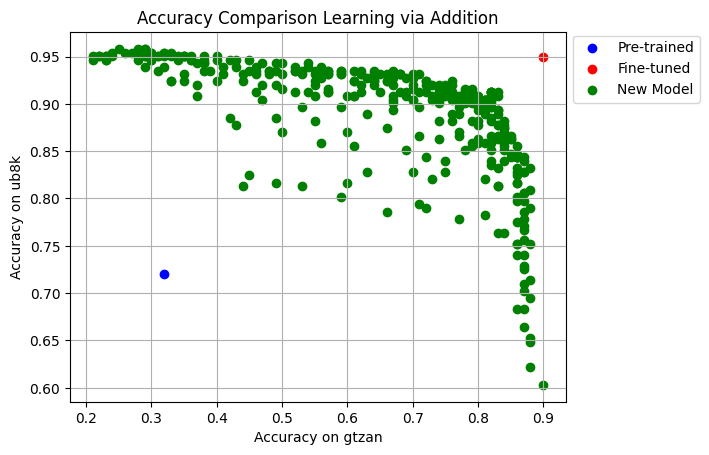

In [ ]:
acc_pretrained_1 = 0.32   # pretrained CLAP model accuracy on gtzan dataset
acc_pretrained_2 = 0.72   # pretrained CLAP model accuracy on ub8k dataset
acc_finetuned_1 = 0.90    # finetuned CLAP model accuracy on gtzan dataset
acc_finetuned_2 = 0.95    # finetuned CLAP model accuracy on ub8k dataset
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"

comparison_acc_learning(acc_pretrained_1, acc_pretrained_2, acc_finetuned_1, acc_finetuned_2, coeff2acc, datasets_name[0], datasets_name[1], dir_to_save, norm=False)

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


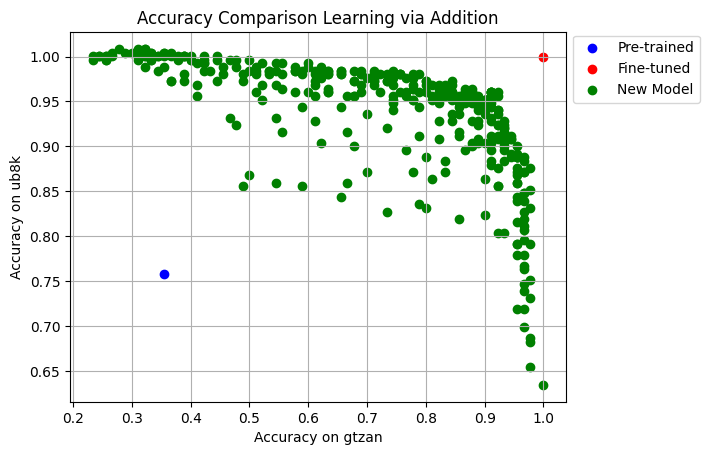

In [ ]:
comparison_acc_learning(acc_pretrained_1, acc_pretrained_2, acc_finetuned_1, acc_finetuned_2, coeff2acc, datasets_name[0], datasets_name[1], dir_to_save, norm=True)

As expected, scaling each task vector by its own coefficient improved the performance of the resulting model. In order to handle the difference in difficulty levels of the tasks, we normalized the accuracy of each task by using the accuracy of the model fine-tuned on that specific task as a reference. After normalization, the accuracies on *GTZAN* and *UrbanSound8k* exceeded 90% and 95%, respectively.

## Task Analogies

Experiments will be conducted on both the *ESC50* and *Huan0806/gender_emotion_recognition* datasets.

An analogy is in the form of:
<center>
  A : B = C : D
</center>

Let's try to build an audio classifier able to perform well on a new category (e.g. “male_sad”) using data from three related classes that form an analogy relationship (e.g., “female_happy”, “man_happy”, and “female_sad”).

<center>
  female_happy : male_happy = female_sad : male_sad
</center>

General procedure:
\begin{align}
\tau_A &= \theta_{pt} - \theta_{ft\_task_A}\\
\tau_B &= \theta_{pt} - \theta_{ft\_task_B}\\
\tau_C &= \theta_{pt} - \theta_{ft\_task_C}\\
\tau_{new} &= \tau_B + \tau_C - \tau_A\\
\theta_{new} &= \theta_{pt} + \lambda\tau_{new}
\end{align}

In [ ]:
def task_analogy(pretrained_checkpoint, finetuned_datasets):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  finetuned_dir = pretrained_dir = "/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/"

  finetuned_checkpoints = [finetuned_dir+f'finetuned_{ds}.pth' for ds in finetuned_datasets]
  print(finetuned_checkpoints)

  task_vectors = [
    TaskVector(pretrained_checkpoint, finetuned_checkpoint)
    for finetuned_checkpoint in finetuned_checkpoints]

  A, B, C = task_vectors[0], task_vectors[1], task_vectors[2]

  A_neg = -A
  new_task_vector = B + C + A_neg
  coeff = [0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  coeff2acc = {}

  for sc in coeff:
    print(f'\n---  Scaling coefficient: {sc}  ---')
    # Apply the task vector
    model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
    new_clap = new_task_vector.apply_to(model, pretrained_checkpoint, scaling_coef=sc)
    new_clap = new_clap.to(device)

    # Evaluate
    acc = eval_CLAP(new_clap, "D")#, plot_conf_matrix=True)
    coeff2acc[sc] = (acc)

  print("\n--- Resume ---")
  for sc, accs in coeff2acc.items():
    print(f'alpha: {sc} -> {accs}')

  return coeff2acc

In [ ]:
datasets_name = ["A", "B", "C"]
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = task_analogy(pretrained_checkpoint, datasets_name)

['/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_A.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_B.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_C.pth']

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]



Done evaluating on D. Accuracy: 62.75%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]



Done evaluating on D. Accuracy: 72.06%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]



Done evaluating on D. Accuracy: 77.45%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]



Done evaluating on D. Accuracy: 83.33%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]



Done evaluating on D. Accuracy: 85.78%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]



Done evaluating on D. Accuracy: 87.75%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]



Done evaluating on D. Accuracy: 88.73%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]



Done evaluating on D. Accuracy: 91.18%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]



Done evaluating on D. Accuracy: 92.65%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]



Done evaluating on D. Accuracy: 93.63%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



Done evaluating on D. Accuracy: 94.61%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Done evaluating on D. Accuracy: 93.14%

--- Resume ---
alpha:  0.2  ->  0.6274509803921569
alpha:  0.3  ->  0.7205882352941176
alpha:  0.35  ->  0.7745098039215687
alpha:  0.4  ->  0.8333333333333334
alpha:  0.45  ->  0.8578431372549019
alpha:  0.5  ->  0.8774509803921569
alpha:  0.55  ->  0.8872549019607843
alpha:  0.6  ->  0.9117647058823529
alpha:  0.65  ->  0.9264705882352942
alpha:  0.7  ->  0.9362745098039216
alpha:  0.75  ->  0.9509803921568627
alpha:  0.8  ->  0.9509803921568627
alpha:  0.85  ->  0.9509803921568627
alpha:  0.9  ->  0.9509803921568627
alpha:  0.95  ->  0.946078431372549
alpha:  1  ->  0.9313725490196079


In [ ]:
coeff2acc

{0.2: 0.6274509803921569,
 0.3: 0.7205882352941176,
 0.35: 0.7745098039215687,
 0.4: 0.8333333333333334,
 0.45: 0.8578431372549019,
 0.5: 0.8774509803921569,
 0.55: 0.8872549019607843,
 0.6: 0.9117647058823529,
 0.65: 0.9264705882352942,
 0.7: 0.9362745098039216,
 0.75: 0.9509803921568627,
 0.8: 0.9509803921568627,
 0.85: 0.9509803921568627,
 0.9: 0.9509803921568627,
 0.95: 0.946078431372549,
 1: 0.9313725490196079}

In [ ]:
target_dataset = "D"
acc_pt_target = 0.35  # pretrained CLAP model accuracy on D dataset
coeff2acc = {
 0.2: 0.6274509803921569,
 0.3: 0.7205882352941176,
 0.35: 0.7745098039215687,
 0.4: 0.8333333333333334,
 0.45: 0.8578431372549019,
 0.5: 0.8774509803921569,
 0.55: 0.8872549019607843,
 0.6: 0.9117647058823529,
 0.65: 0.9264705882352942,
 0.7: 0.9362745098039216,
 0.75: 0.9509803921568627,
 0.8: 0.9509803921568627,
 0.85: 0.9509803921568627,
 0.9: 0.9509803921568627,
 0.95: 0.946078431372549,
 1: 0.9313725490196079}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


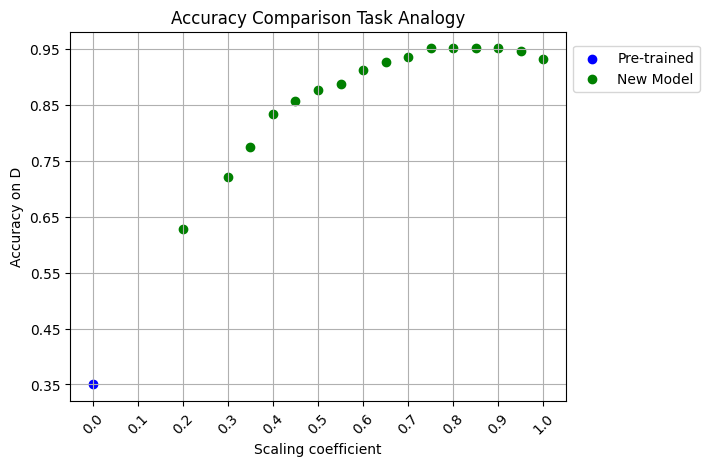

In [ ]:
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"
comparison_acc_analogy(acc_pt_target, coeff2acc, target_dataset, dir_to_save)

The results are excellent. With a scaling coefficient of 0.75, the accuracy on the new task (*D* ) reaches 95%, which is even better than the individual  accuracies of the other three tasks in the analogy (*A*, *B*, and *C* ).

Since the *ESC50* dataset has been used as a support to train the three models in the analogy, we expect an improvement in performance on this dataset as well. Let's test this hypothesis.

In [ ]:
def task_analogy(pretrained_checkpoint, finetuned_datasets, control_dataset, target_dataset):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  finetuned_dir = pretrained_dir = "/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/"

  finetuned_checkpoints = [finetuned_dir+f'finetuned_{ds}.pth' for ds in finetuned_datasets]
  print(finetuned_checkpoints)

  task_vectors = [
    TaskVector(pretrained_checkpoint, finetuned_checkpoint)
    for finetuned_checkpoint in finetuned_checkpoints]

  A, B, C = task_vectors[0], task_vectors[1], task_vectors[2]

  A_neg = -A
  new_task_vector = B + C + A_neg
  coeff = [0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  coeff2acc = {}

  for sc in coeff:
    print(f'\n---  Scaling coefficient: {sc}  ---')
    # Apply the task vector
    model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
    new_clap = new_task_vector.apply_to(model, pretrained_checkpoint, scaling_coef=sc)
    new_clap = new_clap.to(device)

    # Evaluate
    acc_control = eval_CLAP(new_clap, control_dataset)
    acc_target = eval_CLAP(new_clap, target_dataset)
    coeff2acc[sc] = (acc_control, acc_target)

  print("\n--- Resume ---")
  for sc, accs in coeff2acc.items():
    print(f'alpha: {sc}  ->  acc_control: {accs[0]} ({control_dataset}) , acc_target: {accs[1]} ({target_dataset})')

  return coeff2acc

In [ ]:
datasets_name = ["A", "B", "C"]
control_dataset = "esc50"
target_dataset = "D"
pretrained_checkpoint="/content/drive/MyDrive/Audio_Task_Arithmetic/checkpoints/CLAP/pretrained.pth"

coeff2acc = task_analogy(pretrained_checkpoint, datasets_name, control_dataset, target_dataset)

['/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_A.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_B.pth', '/content/drive/MyDrive/Audio_Task_Vectors/checkpoints/CLAP/finetuned_C.pth']

---  Scaling coefficient: 0.2  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 89.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]



Done evaluating on D. Accuracy: 62.75%

---  Scaling coefficient: 0.3  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]



Done evaluating on esc50. Accuracy: 92.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Done evaluating on D. Accuracy: 72.06%

---  Scaling coefficient: 0.35  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 92.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]



Done evaluating on D. Accuracy: 77.45%

---  Scaling coefficient: 0.4  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on esc50. Accuracy: 93.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Done evaluating on D. Accuracy: 83.33%

---  Scaling coefficient: 0.45  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Done evaluating on esc50. Accuracy: 93.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Done evaluating on D. Accuracy: 85.78%

---  Scaling coefficient: 0.5  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on esc50. Accuracy: 92.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on D. Accuracy: 87.75%

---  Scaling coefficient: 0.55  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Done evaluating on esc50. Accuracy: 93.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on D. Accuracy: 88.73%

---  Scaling coefficient: 0.6  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 91.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on D. Accuracy: 91.18%

---  Scaling coefficient: 0.65  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on esc50. Accuracy: 90.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Done evaluating on D. Accuracy: 92.65%

---  Scaling coefficient: 0.7  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Done evaluating on esc50. Accuracy: 89.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on D. Accuracy: 93.63%

---  Scaling coefficient: 0.75  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]



Done evaluating on esc50. Accuracy: 87.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.8  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]



Done evaluating on esc50. Accuracy: 85.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.85  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Done evaluating on esc50. Accuracy: 84.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.9  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]



Done evaluating on esc50. Accuracy: 81.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Done evaluating on D. Accuracy: 95.10%

---  Scaling coefficient: 0.95  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on esc50. Accuracy: 81.00%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Done evaluating on D. Accuracy: 94.61%

---  Scaling coefficient: 1  ---


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Done evaluating on esc50. Accuracy: 78.50%


Test --- : 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Done evaluating on D. Accuracy: 93.14%

--- Resume ---
alpha: 0.2  ->  acc_control: 0.89 (esc50) , acc_target: 0.6274509803921569 (D)
alpha: 0.3  ->  acc_control: 0.92 (esc50) , acc_target: 0.7205882352941176 (D)
alpha: 0.35  ->  acc_control: 0.92 (esc50) , acc_target: 0.7745098039215687 (D)
alpha: 0.4  ->  acc_control: 0.935 (esc50) , acc_target: 0.8333333333333334 (D)
alpha: 0.45  ->  acc_control: 0.935 (esc50) , acc_target: 0.8578431372549019 (D)
alpha: 0.5  ->  acc_control: 0.925 (esc50) , acc_target: 0.8774509803921569 (D)
alpha: 0.55  ->  acc_control: 0.935 (esc50) , acc_target: 0.8872549019607843 (D)
alpha: 0.6  ->  acc_control: 0.915 (esc50) , acc_target: 0.9117647058823529 (D)
alpha: 0.65  ->  acc_control: 0.905 (esc50) , acc_target: 0.9264705882352942 (D)
alpha: 0.7  ->  acc_control: 0.89 (esc50) , acc_target: 0.9362745098039216 (D)
alpha: 0.75  ->  acc_control: 0.87 (esc50) , acc_target: 0.9509803921568627 (D)
alpha: 0.8  ->  acc_control: 0.855 (esc50) , acc_target: 0.95098

In [ ]:
coeff2acc

{0.2: (0.89, 0.6274509803921569),
 0.3: (0.92, 0.7205882352941176),
 0.35: (0.92, 0.7745098039215687),
 0.4: (0.935, 0.8333333333333334),
 0.45: (0.935, 0.8578431372549019),
 0.5: (0.925, 0.8774509803921569),
 0.55: (0.935, 0.8872549019607843),
 0.6: (0.915, 0.9117647058823529),
 0.65: (0.905, 0.9264705882352942),
 0.7: (0.89, 0.9362745098039216),
 0.75: (0.87, 0.9509803921568627),
 0.8: (0.855, 0.9509803921568627),
 0.85: (0.845, 0.9509803921568627),
 0.9: (0.815, 0.9509803921568627),
 0.95: (0.81, 0.946078431372549),
 1: (0.785, 0.9313725490196079)}

In [ ]:
coeff2acc = {
 0.2: (0.89, 0.6274509803921569),
 0.3: (0.92, 0.7205882352941176),
 0.35: (0.92, 0.7745098039215687),
 0.4: (0.935, 0.8333333333333334),
 0.45: (0.935, 0.8578431372549019),
 0.5: (0.925, 0.8774509803921569),
 0.55: (0.935, 0.8872549019607843),
 0.6: (0.915, 0.9117647058823529),
 0.65: (0.905, 0.9264705882352942),
 0.7: (0.89, 0.9362745098039216),
 0.75: (0.87, 0.9509803921568627),
 0.8: (0.855, 0.9509803921568627),
 0.85: (0.845, 0.9509803921568627),
 0.9: (0.815, 0.9509803921568627),
 0.95: (0.81, 0.946078431372549),
 1: (0.785, 0.9313725490196079)
}

Directory '/content/drive/MyDrive/Audio_Task_Vectors/plots/CLAP/' already exists.


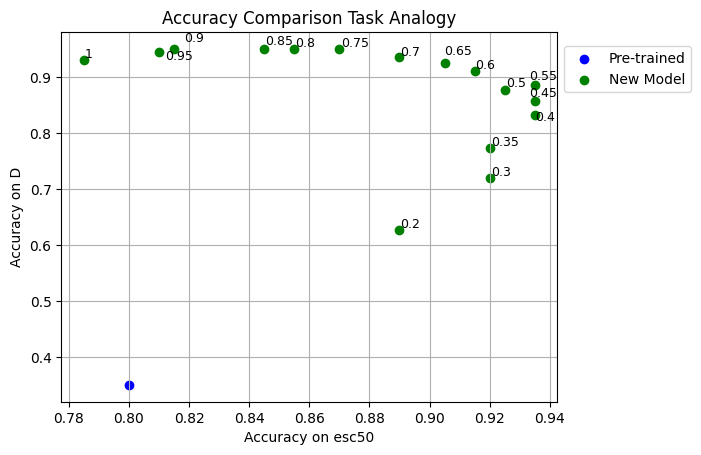

In [ ]:
control_dataset = "esc50"
target_dataset = "D"
acc_pt_control = 0.80
acc_pt_target = 0.35
dir_to_save = "/content/drive/MyDrive/Audio_Task_Arithmetic/plots/CLAP/"

comparison_acc_analogy_control(acc_pt_control, acc_pt_target, coeff2acc, control_dataset, target_dataset, dir_to_save)

As expected, the final model outperforms the pre-trained model, even on the control dataset (*ESC50* ). However, achieving the highest accuracy on the D dataset necessitates accepting only a marginal improvement in performance for the control dataset.